In [307]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [369]:
import os
from pathlib import Path
from unicodedata import category

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import statistics
import pandas as pd
import numpy as np
import functools
from IPython.core.pylabtools import figsize
from matplotlib.lines import lineStyles
from matplotlib.pyplot import xlabel, tight_layout

In [371]:
import  os
os.getcwd()

'/Users/eric/Documents/SchoolCourses/PaGamO/analyze'

In [372]:
df_question = pd.read_parquet("../data/raw/experiment-2025-q1/ntuecon_experiment_250525/question_structure.parquet")

#conn = duckdb.connect("./data/raw/experiment-2025-q1/ntuecon_experiment_250525/target_book_volume_log.parquet")
df_book_vol = pd.read_parquet("../data/raw/experiment-2025-q1/ntuecon_experiment_250525/target_book_volume_log.parquet")

#conn = duckdb.connect("./data/raw/experiment-2025-q1/ntuecon_experiment_250525/target_user_answer_log.parquet")
df_user_ans = pd.read_parquet("../data/raw/experiment-2025-q1/ntuecon_experiment_250603/target_user_answer_log_2025-06-03.parquet")

#conn = duckdb.connect("./data/raw/experiment-2025-q1/ntuecon_experiment_250525/target_user_info.parquet")
df_user_info = pd.read_parquet("../data/raw/experiment-2025-q1/ntuecon_experiment_250603/target_user_info_2025-06-03.parquet")


In [380]:
df_question= pd.read_parquet("/Users/eric/Documents/SchoolCourses/PaGamO/data/raw/experiment-2025-q1/ntuecon_experiment_250525/question_structure.parquet")
df_user_ans_05 = pd.read_parquet("/Users/eric/Documents/SchoolCourses/PaGamO/data/raw/experiment-2025-q1/ntuecon_experiment_250525/target_user_answer_log.parquet")
df_user_info_05 = pd.read_parquet('/Users/eric/Documents/SchoolCourses/PaGamO/data/raw/experiment-2025-q1/ntuecon_experiment_250603/target_user_answer_log_2025-06-03.parquet')
daily_stat = pd.read_parquet(
    '/data/raw/experiment-2025-q1/ntuecon_experiment_250603/target_gc_daily_stat_2025-06-03.parquet')
course = pd.read_parquet("/data/raw/experiment-2025-q1/ntuecon_experiment_250603/target_gc_course_2025-06-03.parquet")

In [395]:
df_user_ans

,created_at_utc8,is_correct,id,user_id,gamecharacter_id,question_id,section_id,is_self_selected
0,2025-04-07 06:46:56,0,6595945214932325692,-3249352243235716427,3330377101065030111,-7936141219324853923,-7762540289828691307,1
1,2025-04-07 07:52:39,1,-5222855874737291371,3273147433857765150,356279179463274145,2853870173158392294,-2781824346269032144,1
2,2025-04-07 06:51:41,0,7364336803782291084,-3249352243235716427,3330377101065030111,8566446823861884258,-7762540289828691307,1
3,2025-04-07 06:50:41,1,4853917661418598152,-5626563041751353776,-4382378208523760646,6709721830382152393,-1928396610704104816,1
4,2025-04-07 06:43:26,1,1627867690492665020,2447161729801205251,-4912858251722698488,-6974387077083482475,-2843992686691078070,1
...,...,...,...,...,...,...,...,...
4093015,2025-02-21 17:10:57,0,-1386484249962799908,8980725452240579208,-5488920920168314304,4793657926878542855,5223737939809232457,0
4093016,2025-02-21 17:15:34,1,-730056865107735236,8980725452240579208,-5488920920168314304,6276386061561971683,5223737939809232457,0
4093017,2025-02-21 16:44:20,0,-4983387610093783337,8980725452240579208,-5488920920168314304,-4435798821471802221,5223737939809232457,0
4093018,2025-02-21 17:04:27,1,7588829874170113238,-4559751751593298829,-8370623403166806182,-9013829383219240211,-247801341597882458,0


In [309]:

testdff = pd.read_json("/Users/eric/Documents/SchoolCourses/PaGamO/data/processed/session_data.json")


In [310]:
os.getcwd()
testdff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21497 entries, (-9215975131138636025, 2806305522055252713, 1) to (9220452508174186299, -7188733719598119482, 9)
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               21497 non-null  int64         
 1   gamecharacter_id      21497 non-null  int64         
 2   session_id            21497 non-null  int64         
 3   is_correct            21497 non-null  object        
 4   difficulty_level      21497 non-null  object        
 5   experiment_index      21497 non-null  object        
 6   question_id           21497 non-null  object        
 7   subject_name          21497 non-null  object        
 8   section_id            21497 non-null  object        
 9   section_name          21497 non-null  object        
 10  school_city           21497 non-null  object        
 11  created_at            21497 non-null  object       

In [311]:

# filter datas
testdff['experiment_mode'] = testdff['experiment_mode'].fillna(-1)
testdff.sort_values(by=['start_time'])
#testdff.drop_duplicates( ['user_id','experiment_mode'],inplace=True)
testdff.query('subject_name_mode == "數學" and manual_book_vol_mode == 5',inplace=True)
testdff.query('answer_length >= 12',inplace=True)

# non-filter the diff seq
non_filter_seq_df = testdff.copy()

# 篩選前兩題、後兩題一致 -> [1,2,[3],1,[3],1,2,2]
conditions = {0:  1,
              1:  2,
              #5:  1,
              9:  1,
              10: 2,
              11: 2,
              }

mask = pd.Series(True, index=testdff.index)

for pos, val in conditions.items():
    print(f'finish {pos}')
    mask &= (testdff['difficulty_level'].str[pos] == val)

testdfff = testdff[mask]

finish 0
finish 1
finish 9
finish 10
finish 11


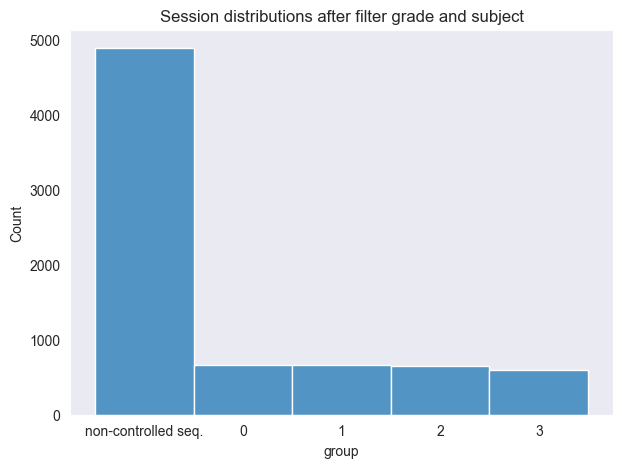

In [312]:

# draw the hist of experiment mode
plt.figure(figsize=(7,5))
sns.histplot(data=testdff, x='experiment_mode', discrete=True)
plt.grid(False)
plt.xlabel('group')
plt.xticks([-1, 0, 1, 2, 3], ['non-controlled seq.', '0', '1', '2', '3'])
plt.title('Session distributions after filter grade and subject')
plt.savefig("../data/results/hist_non_filter_seq.png",dpi=600)


In [313]:

# add group -2
testdfff['difficult_mean_12'] = testdfff['difficulty_level'].apply(lambda x : np.mean(x[:12]))
# testdfff.loc[(testdfff['experiment_mode'] == -1) & (testdfff['difficult_mean_12'] > 1.79),'experiment_mode'] = -2

/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/13812029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdfff['difficult_mean_12'] = testdfff['difficulty_level'].apply(lambda x : np.mean(x[:12]))


In [314]:
testdfff.info()
testdfff.groupby('experiment_mode').count()
testdff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, (-9167949940408139786, 4032858197546372387, 1) to (9191805119663162572, -25535851136541842, 1)
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               614 non-null    int64         
 1   gamecharacter_id      614 non-null    int64         
 2   session_id            614 non-null    int64         
 3   is_correct            614 non-null    object        
 4   difficulty_level      614 non-null    object        
 5   experiment_index      614 non-null    object        
 6   question_id           614 non-null    object        
 7   subject_name          614 non-null    object        
 8   section_id            614 non-null    object        
 9   section_name          614 non-null    object        
 10  school_city           614 non-null    object        
 11  created_at            614 non-null    object        
 1

In [315]:
testdfff.loc[:,'answer_flat'] = testdfff['answer'].copy().apply(lambda lst: [x[2] for x in lst])
testdfff.loc[:,'a_percentile'] = testdfff['answer_flat'].copy().apply(lambda lst : lst.count('A')/len(lst))

#testdfff
#testdfff.query('a_percentile < 0.5')

/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/4172765948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdfff.loc[:,'answer_flat'] = testdfff['answer'].copy().apply(lambda lst: [x[2] for x in lst])
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/4172765948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdfff.loc[:,'a_percentile'] = testdfff['answer_flat'].copy().apply(lambda lst : lst.count('A')/len(lst))


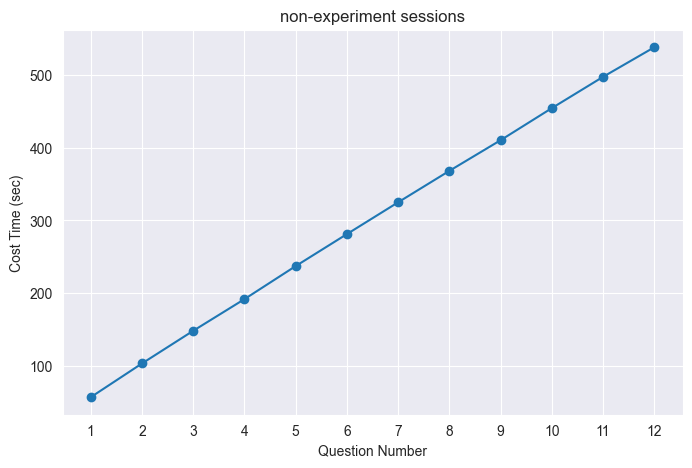

In [316]:
# for non filter seq version
non_filter_seq_df = non_filter_seq_df[non_filter_seq_df['experiment_mode']==-1]
mean_seqs = []
for seq in non_filter_seq_df['time_diff']:
    assert(len(seq) >= 12)
    if len(seq) == 12:
        padded = seq[1:12] + [np.nan]
    else:
        padded = seq[1:13]
    mean_seqs.append(padded)

mean_seqs =  np.array(mean_seqs, dtype='float')
mean_seqs = np.nanmean(mean_seqs,axis = 0)
mean_seqs = np.cumsum(mean_seqs)
plt.figure(figsize = (8,5))
plt.plot(range(1, len(mean_seqs)+1), mean_seqs, marker='o')
plt.xticks(np.arange(1,13))
plt.ylabel('Cost Time (sec)')
plt.xlabel('Question Number')
plt.title(f'non-experiment sessions')
plt.grid(True)
plt.savefig("../data/results/non_filtered_accumulation_time_cost.png",dpi=600)

experiment_mode
-1.0    [8.76974280925261, 13.269218240260713, 18.5037...
 0.0    [3.9216315417214083, 14.154579354876839, 23.52...
 1.0    [11.145449733890151, 17.39122090542763, 20.964...
 2.0    [3.9795531527068664, 8.46494167142146, 10.8986...
 3.0    [10.872234546722561, 16.755064862656788, 21.06...
Name: time_diff, dtype: object


"\n# 畫折線圖\nplt.figure(figsize=(10, 6))\n\nfor exp_mode, seq in avg_seqs.items():\n    plt.plot(range(1, len(seq)), seq[1:], marker='o', label=f'Group {exp_mode}')\n\nplt.xticks()\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n"

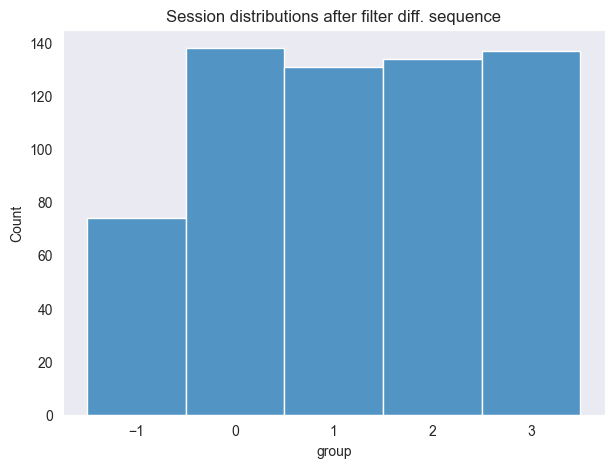

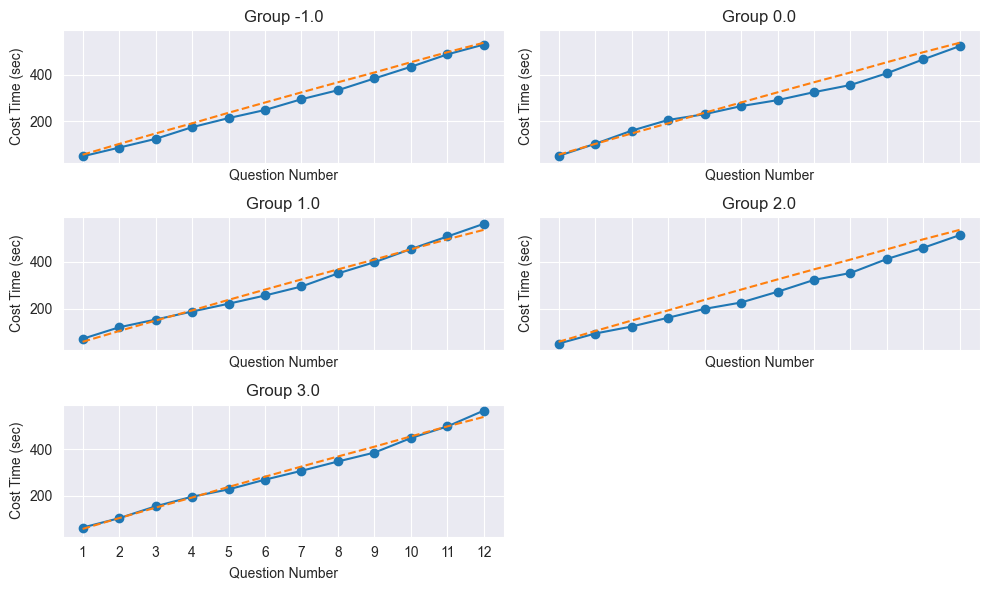

In [317]:
# show the percentile after filter
plt.figure(figsize=(7,5))
sns.histplot(data = testdfff,x='experiment_mode',discrete=True)
plt.grid(False)
plt.xlabel('group')
plt.title('Session distributions after filter diff. sequence')
plt.savefig("../data/results/hist_filtered_seq.png",dpi=600)

# time cost
def list_avg_per_position(series_of_lists):
    # 將所有 list padding 成等長
    max_len = 12
    matrix = []
    for lst in series_of_lists:
        if len(lst)>12:
            padded = lst[1:max_len+1]
        else:
            padded =  lst[1:max_len] + [np.nan]
        matrix.append(padded)

    matrix = np.array(matrix, dtype='float')
    return np.nanmean(matrix, axis=0)

def list_se_per_position(series_of_lists):
    # 將所有 list padding 成等長
    max_len = 12
    matrix = []
    for lst in series_of_lists:
        if len(lst)>12:
            padded = lst[1:max_len+1]
        else:
            padded =  lst[1:max_len] + [np.nan]
        matrix.append(padded)
    matrix = np.array(matrix, dtype='float')
    return np.nanstd(matrix, axis=0)/np.sqrt(len(series_of_lists))

# 累積耗時
avg_seqs = testdfff.groupby('experiment_mode')['time_diff'].apply(list_avg_per_position).apply(lambda x:np.cumsum(x))
#累積耗時std
std_seqs = testdfff.groupby('experiment_mode')['time_diff'].apply(list_se_per_position).apply(lambda x:np.cumsum(x))
print(std_seqs)

# 平均耗時
#avg_seqs = testdfff.groupby('experiment_mode')['time_diff'].apply(list_avg_per_position)
# 平均耗時std
#std_seqs = testdfff.groupby('experiment_mode')['time_diff'].apply(list_se_per_position)

fig, axs = plt.subplots(3, 2, figsize=(10, 6),sharey=True,sharex=True)  # 把 figsize 移到這裡
axs = axs.flatten()

for i, (exp_mode, seq) in enumerate(avg_seqs.items()):
    ax = axs[i]
    #平均位置
    ax.plot(range(1, len(seq)+1), seq, marker='o', label=f'Group {exp_mode}')
    ax.plot(range(1, len(mean_seqs)+1), mean_seqs, linestyle = '--')
    #變異區間
    #ax.fill_between(range(1, len(seq)+1), seq - std_seqs[exp_mode], seq + std_seqs[exp_mode], alpha=0.2)
    ax.set_ylabel('Cost Time (sec)')
    ax.set_xlabel('Question Number')
    ax.set_title(f'Group {exp_mode}')
    ax.set_xticks(np.arange(1,13))
    ax.grid(True)

# 清掉多餘的子圖（如果 corr_lst 少於 6 組）
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])


plt.tight_layout()
plt.savefig("../data/results/accumulation_time_cost.png",dpi=600)
"""
# 畫折線圖
plt.figure(figsize=(10, 6))

for exp_mode, seq in avg_seqs.items():
    plt.plot(range(1, len(seq)), seq[1:], marker='o', label=f'Group {exp_mode}')

plt.xticks()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""

In [318]:
testdfff.head()

,user_id,gamecharacter_id,session_id,is_correct,difficulty_level,experiment_index,question_id,subject_name,section_id,section_name,...,start_time,end_time,session_length,answer_length,experiment_mode,manual_book_vol_mode,subject_name_mode,difficult_mean_12,answer_flat,a_percentile
"(-9167949940408139786, 4032858197546372387, 1)",-9167949940408139786,4032858197546372387,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4680614589130178593, -1794677401750382001, -1...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-9042528178512436726, -9042528178512436726, -...","[5 十進位結構, 5 十進位結構, 5 十進位結構, 5 十進位結構, 5 十進位結構, ...",...,2025-04-29 18:55:30,2025-04-29 19:47:16,3106,36,1.0,5,數學,1.25,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",1.0
"(-9158103991383553355, 7471321155863990421, 1)",-9158103991383553355,7471321155863990421,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]","[1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5986642740406154097, -1814475752912975980, 57...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,2025-04-15 21:23:24,2025-04-15 21:29:04,340,13,0.0,5,數學,1.50,"[A, A, A, A, A, A, A, A, A, A, A, A, A]",1.0
"(-9113995040844985336, -7352949570814663240, 17)",-9113995040844985336,-7352949570814663240,17,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[-8965973984069043919, -766303834734867880, 88...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-3986686354055251492, -3986686354055251492, -...","[10 生活中的大單位與折線圖, 10 生活中的大單位與折線圖, 10 生活中的大單位與折線...",...,2025-04-17 08:31:53,2025-04-17 08:43:04,671,15,2.0,5,數學,1.50,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A]",1.0
"(-9044793583754464406, 4996781549453727855, 8)",-9044793583754464406,4996781549453727855,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[5986642740406154097, -1814475752912975980, 57...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,2025-04-11 14:33:00,2025-04-11 14:59:19,1579,34,2.0,5,數學,1.50,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",1.0
"(-9035012210690751509, 3971146662426855581, 2)",-9035012210690751509,3971146662426855581,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5986642740406154097, -1814475752912975980, 57...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,2025-04-08 23:20:57,2025-04-08 23:43:47,1370,20,0.0,5,數學,1.50,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",1.0


In [319]:
testdfff['total_length'] = testdfff['time_diff'].apply(lambda x : np.nansum([t if t is not None else np.nan for  t in x]))
testdfff['q_number'] = testdfff['time_diff'].apply(lambda x : len(x))
testdfff['over_12'] = testdfff['q_number'].apply(lambda x: 1 if x >12 else 0)
tempdf = testdfff[['total_length', 'experiment_mode','q_number' ]]
tempdf = tempdf[tempdf['experiment_mode'] != -1]
tempdf = tempdf[tempdf['total_length']<= 3*60*60]

/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/4099425848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdfff['total_length'] = testdfff['time_diff'].apply(lambda x : np.nansum([t if t is not None else np.nan for  t in x]))
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/4099425848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdfff['q_number'] = testdfff['time_diff'].apply(lambda x : len(x))
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_2800

In [320]:
testdfff.groupby('experiment_mode')['over_12'].describe()


,count,mean,std,min,25%,50%,75%,max
experiment_mode,,,,,,,,
-1.0,74.0,0.932432,0.252716,0.0,1.0,1.0,1.0,1.0
0.0,138.0,0.963768,0.187547,0.0,1.0,1.0,1.0,1.0
1.0,131.0,0.954198,0.209857,0.0,1.0,1.0,1.0,1.0
2.0,134.0,0.947761,0.223343,0.0,1.0,1.0,1.0,1.0
3.0,137.0,0.934307,0.248655,0.0,1.0,1.0,1.0,1.0


In [321]:
%R -i tempdf

In [322]:
%%R
levels(tempdf$experiment_mode)
summary(tempdf)


  total_length     experiment_mode    q_number     
 Min.   :  183.0   Min.   :0.000   Min.   : 12.00  
 1st Qu.:  612.0   1st Qu.:0.000   1st Qu.: 16.00  
 Median :  992.5   Median :2.000   Median : 22.00  
 Mean   : 1386.2   Mean   :1.585   Mean   : 25.48  
 3rd Qu.: 1716.5   3rd Qu.:3.000   3rd Qu.: 32.00  
 Max.   :10714.0   Max.   :3.000   Max.   :104.00  


In [323]:
%%R
tempdf$experiment_mode <- factor(
  tempdf$experiment_mode,
  levels = c(-1, 0, 1, 2, 3)
)

tempdf$experiment_mode <- relevel(factor(tempdf$experiment_mode), ref = "0")

model <- lm(data = tempdf, formula = total_length/60 ~ experiment_mode)
summary(model)


Call:
lm(formula = total_length/60 ~ experiment_mode, data = tempdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.058 -12.598  -6.834   5.799 152.458 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        26.108      2.555  10.217   <2e-16 ***
experiment_mode1   -2.213      3.897  -0.568    0.571    
experiment_mode2   -3.648      3.644  -1.001    0.318    
experiment_mode3   -5.600      3.496  -1.602    0.111    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.96 on 232 degrees of freedom
Multiple R-squared:  0.0115,	Adjusted R-squared:  -0.001279 
F-statistic:   0.9 on 3 and 232 DF,  p-value: 0.4419



In [324]:
%%R

model <- lm(data = tempdf, formula = q_number ~ experiment_mode)

summary(model)


Call:
lm(formula = q_number ~ experiment_mode, data = tempdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.674  -9.433  -3.763   6.627  78.148 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       25.8525     1.6740  15.443   <2e-16 ***
experiment_mode1   0.8215     2.5531   0.322    0.748    
experiment_mode2   0.5204     2.3874   0.218    0.828    
experiment_mode3  -2.2382     2.2900  -0.977    0.329    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.07 on 232 degrees of freedom
Multiple R-squared:  0.009113,	Adjusted R-squared:  -0.0037 
F-statistic: 0.7112 on 3 and 232 DF,  p-value: 0.5462



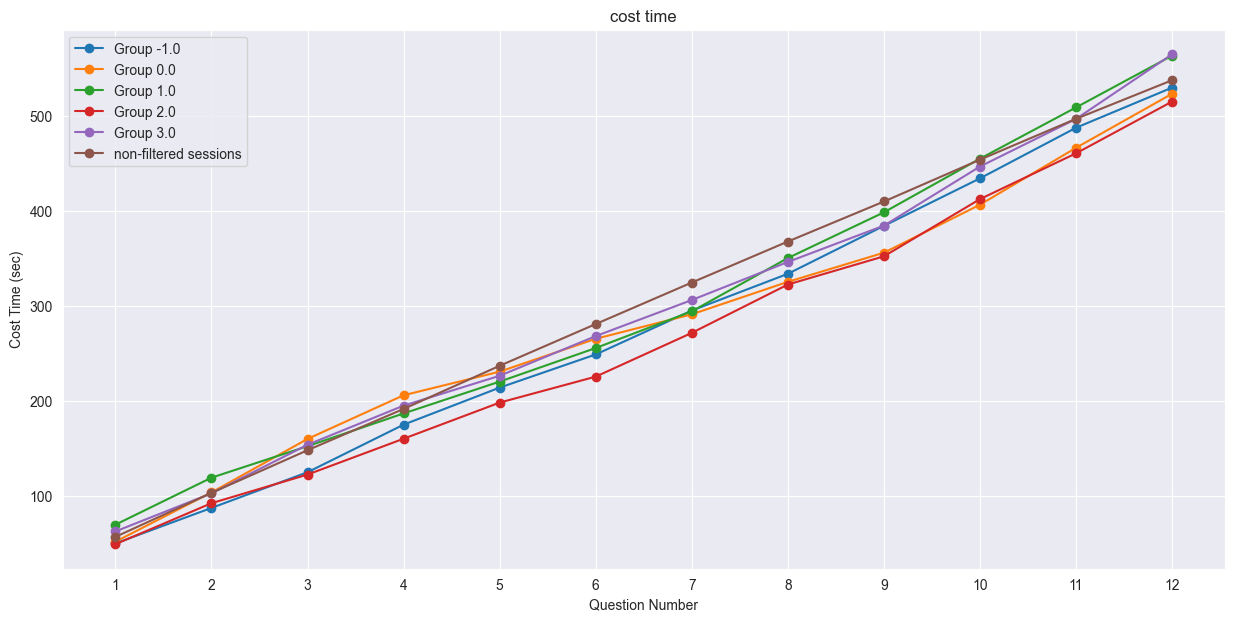

In [325]:
plt.figure(figsize=(15,7))
for i, (exp_mode, seq) in enumerate(avg_seqs.items()):
    plt.plot(range(1, len(seq)+1), seq, marker='o', label=f'Group {exp_mode}')
plt.plot(range(1, len(mean_seqs)+1), mean_seqs, marker='o', label = 'non-filtered sessions')
plt.ylabel('Cost Time (sec)')
plt.xlabel('Question Number')
plt.title(f'cost time')
plt.xticks(np.arange(1,13))
plt.legend()
plt.grid(True)
plt.savefig("../data/results/all_accumulation_time_cost.png",dpi=600)

/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/2628259556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdfff['difficult_mean_12'] = testdfff['difficulty_level'].apply(lambda x : np.mean(x[:12]))


,count,mean,std,min,25%,50%,75%,max
experiment_mode,,,,,,,,
-1.0,74.0,1.652027,0.154436,1.250000,1.583333,1.666667,1.75,2.000000
0.0,138.0,1.505435,0.046367,1.416667,1.500000,1.500000,1.50,2.000000
1.0,131.0,1.267812,0.103366,1.250000,1.250000,1.250000,1.25,2.000000
2.0,134.0,1.501866,0.021597,1.500000,1.500000,1.500000,1.50,1.750000
3.0,137.0,1.511557,0.072298,1.416667,1.500000,1.500000,1.50,2.083333


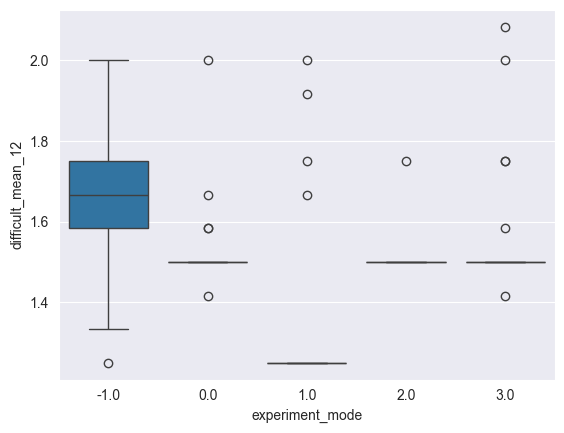

In [326]:
# show the difficult level between groups
testdfff['difficult_mean_12'] = testdfff['difficulty_level'].apply(lambda x : np.mean(x[:12]))
sns.boxplot(data = testdfff,x = 'experiment_mode',y= 'difficult_mean_12')
testdfff.groupby('experiment_mode')['difficult_mean_12'].describe()

/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/3913427047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdfff['difficult_dif_1_12'] = testdfff['difficulty_level'].apply(lambda x : x[:12].count(1))
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/3913427047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdfff['difficult_dif_2_12'] = testdfff['difficulty_level'].apply(lambda x : x[:12].count(2))
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002

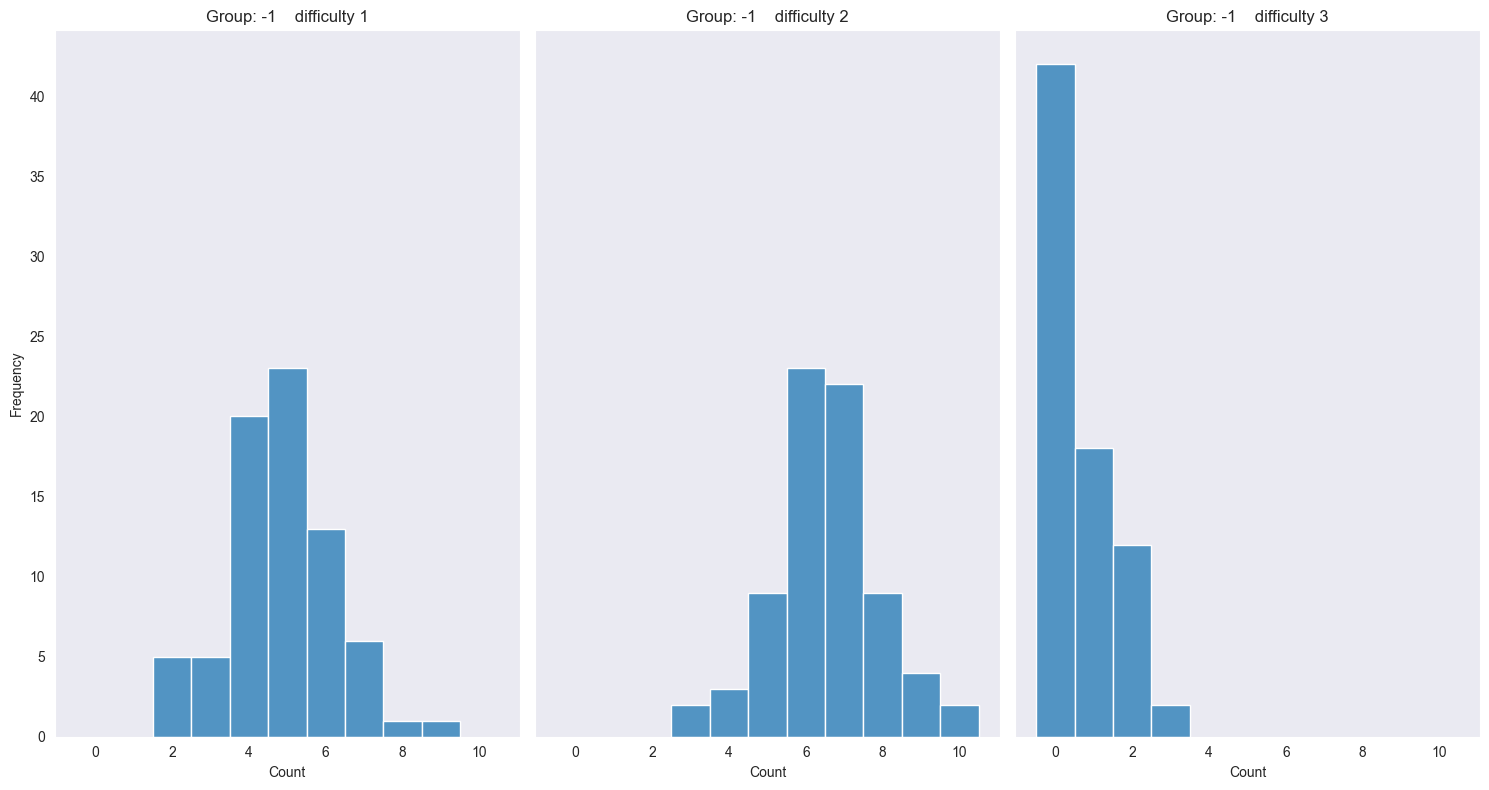

In [327]:
# 過濾掉缺少 experiment_mode 或 difficulty_level 的資料
testdfff['difficult_dif_1_12'] = testdfff['difficulty_level'].apply(lambda x : x[:12].count(1))
testdfff['difficult_dif_2_12'] = testdfff['difficulty_level'].apply(lambda x : x[:12].count(2))
testdfff['difficult_dif_3_12'] = testdfff['difficulty_level'].apply(lambda x : x[:12].count(3))
fig, axs = plt.subplots(1, 3, figsize=(15, 8), sharey=True,sharex=True)
groups = [ -1]
cols = ['difficult_dif_1_12', 'difficult_dif_2_12', 'difficult_dif_3_12']

for i, group in enumerate(groups):
    dft = testdfff[testdfff['experiment_mode'] == group]
    for j, col in enumerate(cols):
        ax = axs[j]
        sns.histplot(data=dft, x=col, ax=ax, bins=12, discrete=True)
        ax.set_title(f'Group: {group}    difficulty {col
                     .replace('difficult_dif_',"")
                     .replace('_12',"")
        }')
        ax.set_xlabel('Count')
        ax.set_ylabel('Frequency')
        ax.grid(False)

plt.tight_layout()
plt.savefig('../data/results/distribution.png',dpi= 600)
#sns.histplot(data=testdfff,x = 'experiment_mode',y = 'difficult_dif_1_12',discrete=True)

<Axes: xlabel='experiment_mode', ylabel='total_time_cost'>

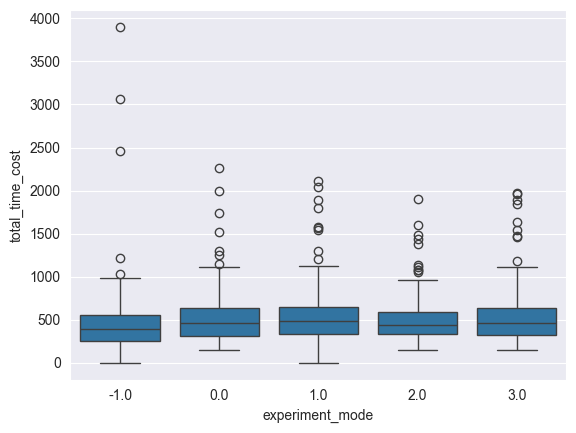

In [328]:
# average time cost to 12 questions, and average cost to each questions-> 1:13 question time spand
tempdf = testdfff.copy()
tempdf['total_time_cost'] = tempdf['time_diff'].apply(lambda x : np.sum(x[1:13]))
sns.boxplot(data=tempdf,x = 'experiment_mode', y = 'total_time_cost')

"\nnon_filter_seq_df = non_filter_seq_df[non_filter_seq_df['experiment_mode']==-1]\nmean_seqs = []\nfor seq in non_filter_seq_df['is_correct']:\n    assert(len(seq) >= 12)\n    if len(seq) <= 20:\n        padded = seq[:len(seq)] + [np.nan for _ in range(20 - len(seq))]\n    else:\n        padded = seq[:20]\n    mean_seqs.append(padded)\n\nmean_seqs =  np.array(mean_seqs, dtype='float')\nmean_seqs = np.nanmean(mean_seqs,axis = 0)\n\nplt.plot(range(1, len(mean_seqs)+1), mean_seqs, marker='o')\nplt.ylim([0.4,1])\nplt.xticks(np.arange(1,21))\nplt.ylabel('Correct Rate')\nplt.xlabel('Question Number')\nplt.title(f'non-experiment sessions')\nplt.grid(True)\n"

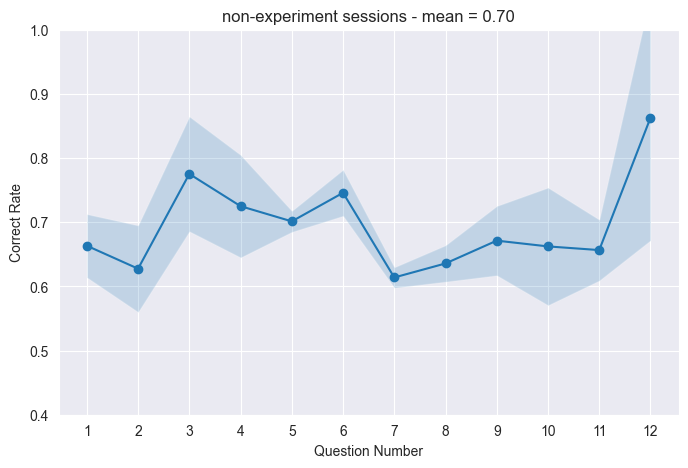

In [329]:
# analyze the correct rate in each order with non seq filter sessions
non_filter_seq_df = non_filter_seq_df[non_filter_seq_df['experiment_mode']==-1]
mean_seqs = []
for seq in non_filter_seq_df['is_correct']:
    assert(len(seq) >= 12)
    if len(seq) == 12:
        padded = seq[:12]
    mean_seqs.append(padded)

mean_seqs =  np.array(mean_seqs, dtype='float')
std_seqs = np.std(mean_seqs,axis=0)
std_seqs /= np.sqrt(len(non_filter_seq_df))
mean_seqs = np.nanmean(mean_seqs,axis = 0)


plt.figure(figsize=(8,5))
plt.plot(range(1, len(mean_seqs)+1), mean_seqs, marker='o')
plt.fill_between(range(1, len(mean_seqs)+1), mean_seqs - std_seqs*1.96, mean_seqs + std_seqs*1.96,alpha = 0.2)
plt.ylim([0.4,1])
plt.xticks(np.arange(1,13))
plt.ylabel('Correct Rate')
plt.xlabel('Question Number')
plt.title(f'non-experiment sessions - mean = {np.mean(mean_seqs):.2f}')
plt.grid(True)
plt.savefig("../data/results/correct_rate_non_filter.png",dpi = 600)

# first 20
"""
non_filter_seq_df = non_filter_seq_df[non_filter_seq_df['experiment_mode']==-1]
mean_seqs = []
for seq in non_filter_seq_df['is_correct']:
    assert(len(seq) >= 12)
    if len(seq) <= 20:
        padded = seq[:len(seq)] + [np.nan for _ in range(20 - len(seq))]
    else:
        padded = seq[:20]
    mean_seqs.append(padded)

mean_seqs =  np.array(mean_seqs, dtype='float')
mean_seqs = np.nanmean(mean_seqs,axis = 0)

plt.plot(range(1, len(mean_seqs)+1), mean_seqs, marker='o')
plt.ylim([0.4,1])
plt.xticks(np.arange(1,21))
plt.ylabel('Correct Rate')
plt.xlabel('Question Number')
plt.title(f'non-experiment sessions')
plt.grid(True)
"""

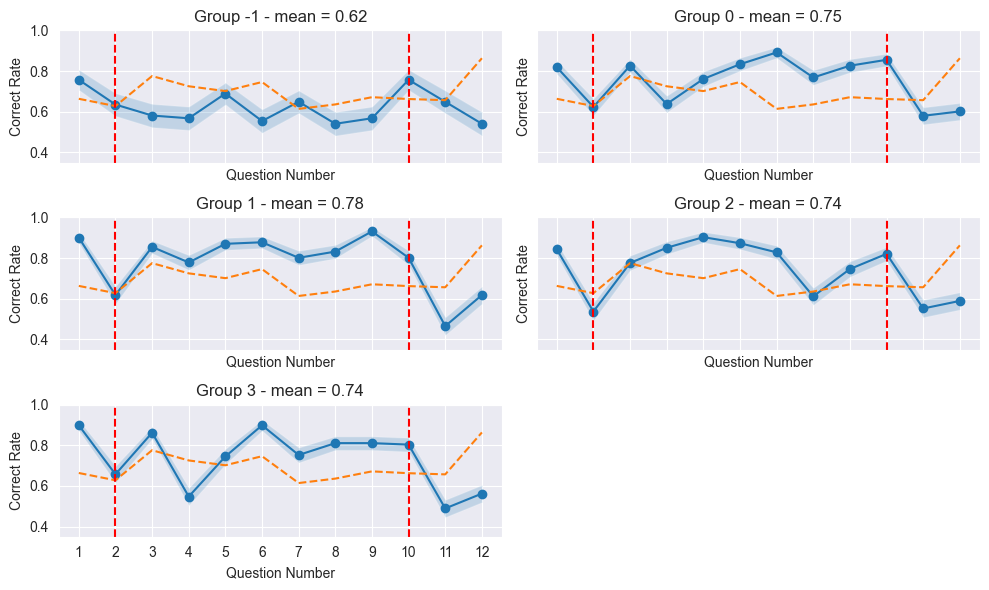

In [330]:
# analyze the correct rate in each order
def correct_rate_simp(series_lists):
    matrix = []
    for lis in series_lists:
        matrix.append(lis[:12])
    matrix = np.array(matrix, dtype='float')
    return np.nanmean(matrix,axis = 0)

def correct_rate_simp_std(series_lists):
    matrix = []
    for lis in series_lists:
        matrix.append(lis[:12])
    matrix = np.array(matrix, dtype='float')
    return np.nanstd(matrix,axis = 0)/np.sqrt(len(series_lists))


corr_lst = tempdf.groupby('experiment_mode')['is_correct'].apply(correct_rate_simp)
corr_lst_std = tempdf.groupby('experiment_mode')['is_correct'].apply(correct_rate_simp_std)



fig, axs = plt.subplots(3, 2, figsize=(10, 6),sharey=True,sharex=True)  # 把 figsize 移到這裡
axs = axs.flatten()

for i, (exp_mode, seq) in enumerate(corr_lst.items()):
    ax = axs[i]
    ax.plot(range(1, len(seq)+1), seq, marker='o', label=f'Group {int(exp_mode)}')
    ax.plot(range(1, len(mean_seqs)+1), mean_seqs, linestyle = '--')
    ax.fill_between(range(1, len(seq)+1), seq - corr_lst_std[exp_mode], seq + corr_lst_std[exp_mode],alpha = 0.2)
    ax.set_ylabel('Correct Rate')
    ax.set_xlabel('Question Number')
    ax.set_title(f'Group {int(exp_mode)} - mean = {np.mean(seq):.2f}')
    ax.set_ylim([0.35,1])
    ax.set_xticks(np.arange(1,13))
    ax.axvline(2,linestyle = '--',color = 'r', label = "controlled")
    ax.axvline(10,linestyle = '--',color = 'r', label = "controlled")
    ax.grid(True)

# 清掉多餘的子圖（如果 corr_lst 少於 6 組）
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("../data/results/correct_rate.png",dpi=600)


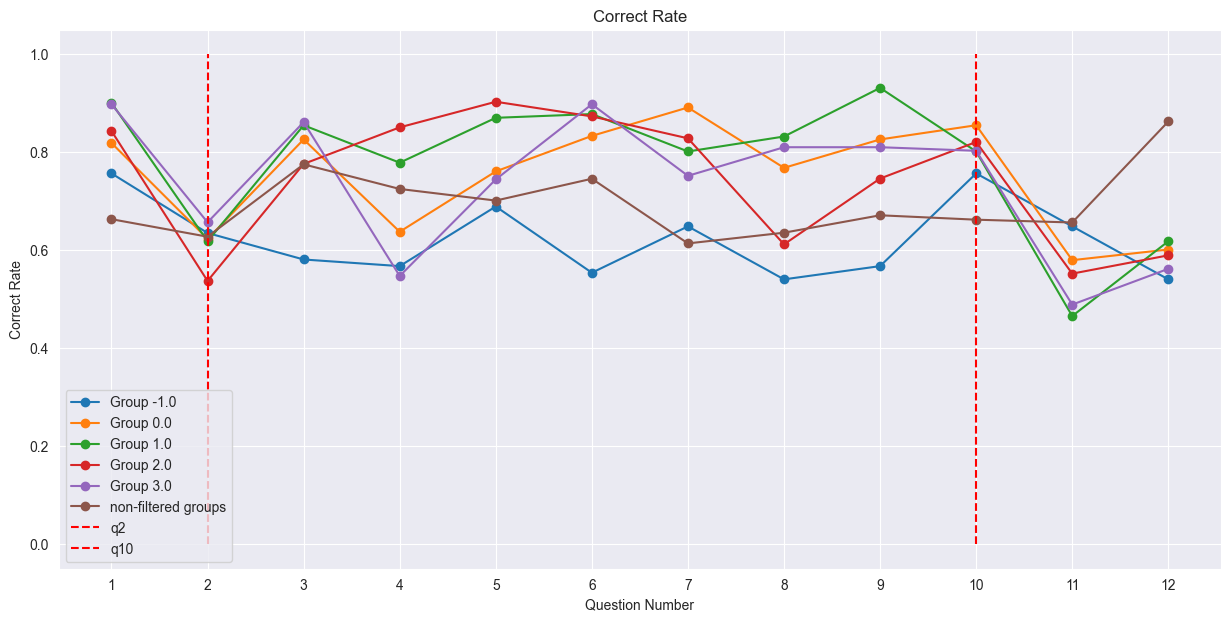

In [331]:
plt.figure(figsize=(15,7))
for i, (exp_mode, seq) in enumerate(corr_lst.items()):
    plt.plot(range(1, len(seq) + 1), seq, marker='o', label=f'Group {exp_mode}')
plt.plot(range(1, len(mean_seqs)+1), mean_seqs, marker='o',label = 'non-filtered groups')
plt.ylabel('Correct Rate')
plt.xlabel('Question Number')
plt.title('Correct Rate')
plt.xticks(np.arange(1, 13))
plt.vlines(2,ymin=0,ymax=1,linestyle = '--',color = 'r', label = "q2")
plt.vlines(10,ymin=0,ymax=1,linestyle = '--',color = 'r', label = "q10")
plt.legend()
plt.grid(True)
plt.savefig("../data/results/all_correct_rate.png",dpi=600)

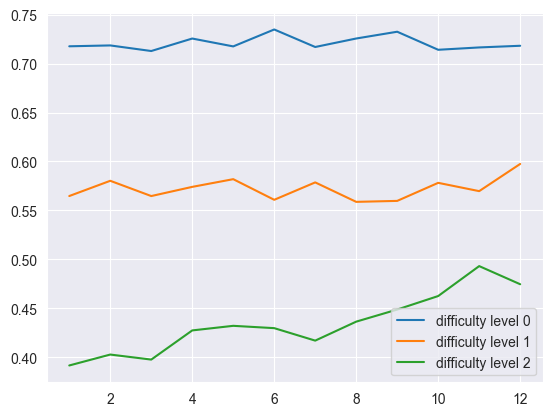

In [332]:
# correct rate separate by difficulty
def correct_rate_by_difficulty(correct_lis:list[list], diff_lis:list[list]):
    diff_mask_1 = np.array([list(map(lambda x : 1 if x == 1 else np.nan,lis[:12])) for lis in diff_lis])
    diff_mask_2 = np.array([list(map(lambda x : 1 if x == 2 else np.nan,lis[:12])) for lis in diff_lis])
    diff_mask_3 = np.array([list(map(lambda x : 1 if x == 3 else np.nan,lis[:12])) for lis in diff_lis])
    correct_matrix = np.array([lis[:12] for lis in correct_lis])
    corr_seqs = [
        np.nanmean(
        np.multiply(correct_matrix,mask),axis = 0
        )
        for mask in [diff_mask_1,diff_mask_2,diff_mask_3]
    ]
    return corr_seqs

seqs = correct_rate_by_difficulty(non_filter_seq_df['is_correct'],non_filter_seq_df['difficulty_level'])
for idx,seq in enumerate(seqs):
    plt.plot(np.arange(1,13),seq,label = f'difficulty level {idx}')
plt.legend()

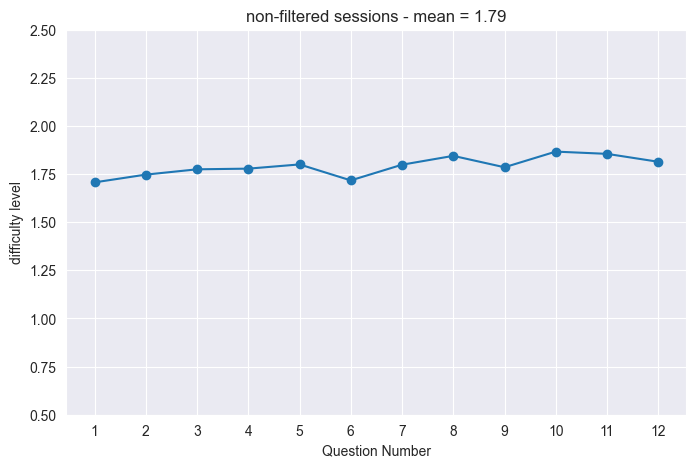

In [333]:
# for non filter seq version of difficult level
non_filter_seq_df = non_filter_seq_df[non_filter_seq_df['experiment_mode']==-1]
mean_seqs = []
for seq in non_filter_seq_df['difficulty_level']:
    assert(len(seq) >= 12)
    if len(seq) == 12:
        padded = seq[:12]
    mean_seqs.append(padded)

mean_seqs =  np.array(mean_seqs, dtype='float')
mean_seqs = np.nanmean(mean_seqs,axis = 0)
plt.figure(figsize=(8,5))
plt.ylim([0.5,2.5])
plt.plot(range(1, len(mean_seqs)+1), mean_seqs, marker='o')
plt.xticks(np.arange(1,13))
plt.ylabel('difficulty level')
plt.xlabel('Question Number')
plt.title(f'non-filtered sessions - mean = {np.mean(mean_seqs):.2f}')
plt.grid(True)
plt.savefig("../data/results/difficulty_level_non_filter.png",dpi = 600)

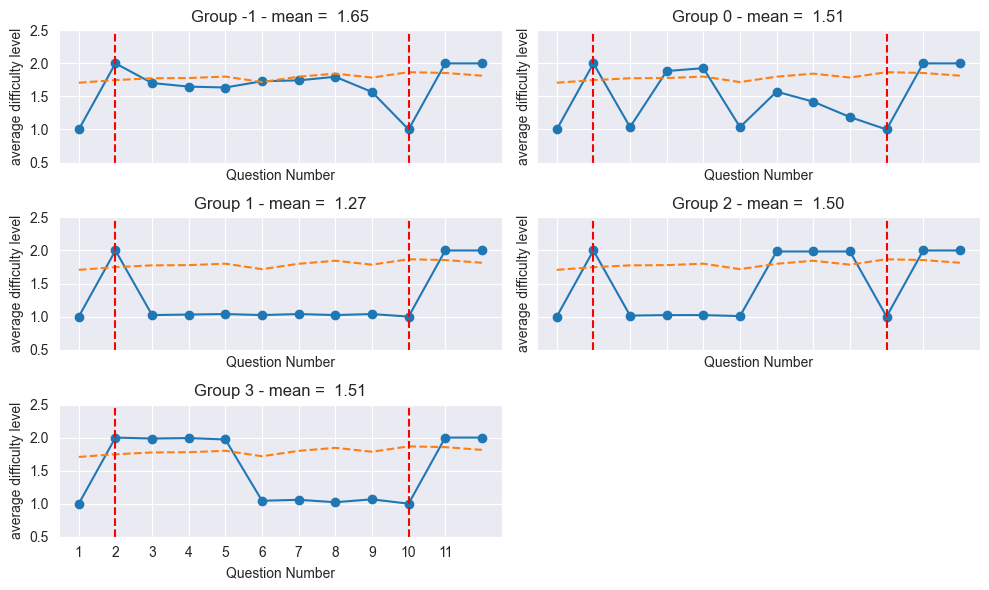

In [334]:
diff_lst = testdfff.groupby('experiment_mode')['difficulty_level'].apply(correct_rate_simp)
diff_lst_sd = testdfff.groupby('experiment_mode')['difficulty_level'].apply(correct_rate_simp_std)

fig, axs = plt.subplots(3, 2, figsize=(10, 6),sharey=True,sharex=True)  # 把 figsize 移到這裡
plt.xticks(np.arange(1,12))
axs = axs.flatten()

for i, (exp_mode, seq) in enumerate(diff_lst.items()):
    ax = axs[i]
    ax.plot(range(1, len(seq)+1), seq, marker='o', label=f'Group {exp_mode} ')
    #ax.fill_between(range(1, len(seq)+1), seq - diff_lst_sd[exp_mode], seq + diff_lst_sd[exp_mode],alpha = 0.2)
    ax.plot(range(1, len(mean_seqs)+1), mean_seqs,linestyle='--',label = 'non-experiment')
    ax.set_ylabel('average difficulty level')
    ax.set_xlabel('Question Number')
    ax.set_title(f'Group {int(exp_mode)} - mean = {np.mean(seq) : .2f}')
    ax.grid(True)
    ax.set_ylim([0.5,2.5])
    ax.axvline(2,linestyle = '--',color = 'r')
    ax.axvline(10,linestyle = '--',color = 'r')


# 清掉多餘的子圖（如果 corr_lst 少於 6 組）
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])


plt.tight_layout()
plt.savefig("../data/results/difficulty_level.png",dpi=600)

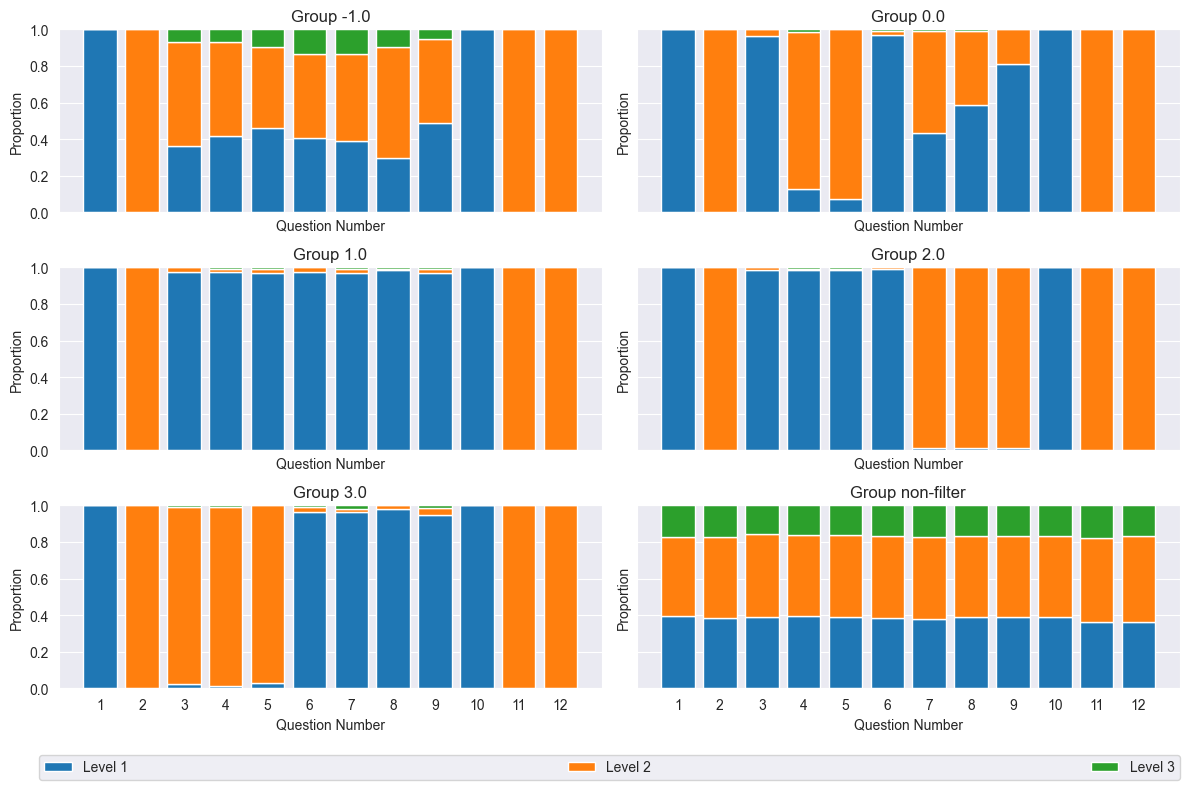

In [335]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

def difficulty_proportions(series_lists, levels=(1, 2, 3), n_questions=12):
    """
    series_lists: pandas Series，每個元素是一個 difficulty_level 的 list
    回傳：一個 dict，key 為難度等級，value 為長度 n_questions 的比例陣列
    """
    # 建立矩陣 (num_samples, n_questions)
    matrix = np.array([lst[:n_questions] for lst in series_lists], dtype=float)
    # 每題非 nan 的樣本數
    valid_counts = np.sum(~np.isnan(matrix), axis=0)
    props = {}
    for lvl in levels:
        # 計算該等級出現次數，再除以 valid_counts
        props[lvl] = np.sum(matrix == lvl, axis=0) / valid_counts
    return props

# 1. 計算每組的難度分佈比例
grouped = testdfff.groupby('experiment_mode')['difficulty_level']
diff_props = {
    mode: difficulty_proportions(series)
    for mode, series in grouped
}

# 2. 畫圖：3x2 子圖，每組一張堆疊長條圖
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()
x = np.arange(1, 13)  # 題號 1–12
levels = (1, 2, 3)

for i, (mode, props) in enumerate(diff_props.items()):
    ax = axs[i]
    bottom = np.zeros_like(x, dtype=float)
    for lvl in levels:
        ax.bar(x, props[lvl], bottom=bottom, label=f'Level {lvl}')
        bottom += props[lvl]
    ax.set_title(f'Group {mode}')
    ax.set_xticks(x)
    ax.set_xlabel('Question Number')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1)
    ax.grid(True)

# 第 1 個子圖加圖例


# 刪除多餘子圖
props = difficulty_proportions(non_filter_seq_df['difficulty_level'])
ax = axs[-1]
bottom = np.zeros_like(x, dtype=float)
for lvl in levels:
    ax.bar(x, props[lvl], bottom=bottom, label=f'Level {lvl}')
    bottom += props[lvl]

ax.set_title(f'Group non-filter')
ax.set_xticks(x)
ax.set_xlabel('Question Number')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1)
ax.grid(True)


ax.legend(bbox_to_anchor=(-1.1, -0.5, 2.1, 2), loc='lower right',ncol = 3, mode="expand", borderaxespad=0.)
plt.tight_layout()
plt.show()


In [336]:
testdfff.groupby('experiment_mode').count()

,user_id,gamecharacter_id,session_id,is_correct,difficulty_level,experiment_index,question_id,subject_name,section_id,section_name,...,subject_name_mode,difficult_mean_12,answer_flat,a_percentile,total_length,q_number,over_12,difficult_dif_1_12,difficult_dif_2_12,difficult_dif_3_12
experiment_mode,,,,,,,,,,,,,,,,,,,,,
-1.0,74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74
0.0,138,138,138,138,138,138,138,138,138,138,...,138,138,138,138,138,138,138,138,138,138
1.0,131,131,131,131,131,131,131,131,131,131,...,131,131,131,131,131,131,131,131,131,131
2.0,134,134,134,134,134,134,134,134,134,134,...,134,134,134,134,134,134,134,134,134,134
3.0,137,137,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137,137,137


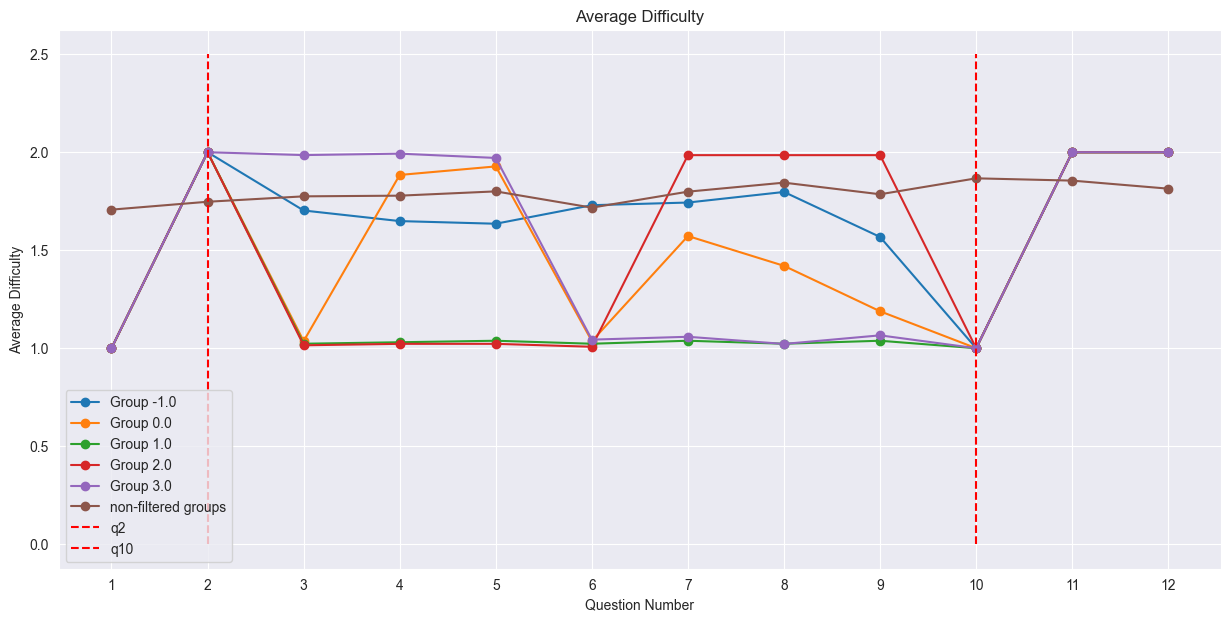

In [337]:
plt.figure(figsize=(15,7))
for i, (exp_mode, seq) in enumerate(diff_lst.items()):
    plt.plot(range(1, len(seq) + 1), seq, marker='o', label=f'Group {exp_mode}')
plt.plot(range(1, len(mean_seqs)+1), mean_seqs, marker='o',label = 'non-filtered groups')
plt.ylabel('Average Difficulty')
plt.xlabel('Question Number')
plt.title('Average Difficulty')
plt.xticks(np.arange(1, 13))
plt.vlines(2,ymin=0,ymax=2.5,linestyle = '--',color = 'r', label = "q2")
plt.vlines(10,ymin=0,ymax=2.5,linestyle = '--',color = 'r', label = "q10")
plt.legend()
plt.grid(True)
plt.savefig("../data/results/all_difficulty_level.png",dpi=600)

In [338]:
testdfff

,user_id,gamecharacter_id,session_id,is_correct,difficulty_level,experiment_index,question_id,subject_name,section_id,section_name,...,subject_name_mode,difficult_mean_12,answer_flat,a_percentile,total_length,q_number,over_12,difficult_dif_1_12,difficult_dif_2_12,difficult_dif_3_12
"(-9167949940408139786, 4032858197546372387, 1)",-9167949940408139786,4032858197546372387,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4680614589130178593, -1794677401750382001, -1...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-9042528178512436726, -9042528178512436726, -...","[5 十進位結構, 5 十進位結構, 5 十進位結構, 5 十進位結構, 5 十進位結構, ...",...,數學,1.25,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",1.0,3106.0,36,1,9,3,0
"(-9158103991383553355, 7471321155863990421, 1)",-9158103991383553355,7471321155863990421,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]","[1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5986642740406154097, -1814475752912975980, 57...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,數學,1.50,"[A, A, A, A, A, A, A, A, A, A, A, A, A]",1.0,340.0,13,1,6,6,0
"(-9113995040844985336, -7352949570814663240, 17)",-9113995040844985336,-7352949570814663240,17,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[-8965973984069043919, -766303834734867880, 88...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-3986686354055251492, -3986686354055251492, -...","[10 生活中的大單位與折線圖, 10 生活中的大單位與折線圖, 10 生活中的大單位與折線...",...,數學,1.50,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A]",1.0,691151.0,15,1,6,6,0
"(-9044793583754464406, 4996781549453727855, 8)",-9044793583754464406,4996781549453727855,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[5986642740406154097, -1814475752912975980, 57...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,數學,1.50,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",1.0,256375.0,34,1,6,6,0
"(-9035012210690751509, 3971146662426855581, 2)",-9035012210690751509,3971146662426855581,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5986642740406154097, -1814475752912975980, 57...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,數學,1.50,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",1.0,2989857.0,20,1,6,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(9091446774295250885, -3817410904508421525, 14)",9091446774295250885,-3817410904508421525,14,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5986642740406154097, -1814475752912975980, 57...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,數學,1.50,"[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...",1.0,2379965.0,28,1,6,6,0
"(9104057424448687281, -9213809197422335026, 17)",9104057424448687281,-9213809197422335026,17,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, ...","[1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[4680614589130178593, -1794677401750382001, -1...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-9042528178512436726, -9042528178512436726, -...

In [339]:
testdfff.loc[:,'answer_flat'] = testdfff['answer'].copy().apply(lambda lst: [x[2] for x in lst])
testdfff.loc[:,'a_percentile'] = testdfff['answer_flat'].copy().apply(lambda lst : lst.count('A')/len(lst))
testdfff.groupby('experiment_mode')['a_percentile'].describe()

,count,mean,std,min,25%,50%,75%,max
experiment_mode,,,,,,,,
-1.0,74.0,0.832831,0.300187,0.000000,0.770149,1.0,1.0,1.0
0.0,138.0,0.995190,0.029150,0.754717,1.000000,1.0,1.0,1.0
1.0,131.0,0.988755,0.071235,0.418605,1.000000,1.0,1.0,1.0
2.0,134.0,0.994807,0.030675,0.760870,1.000000,1.0,1.0,1.0
3.0,137.0,0.995074,0.036038,0.666667,1.000000,1.0,1.0,1.0


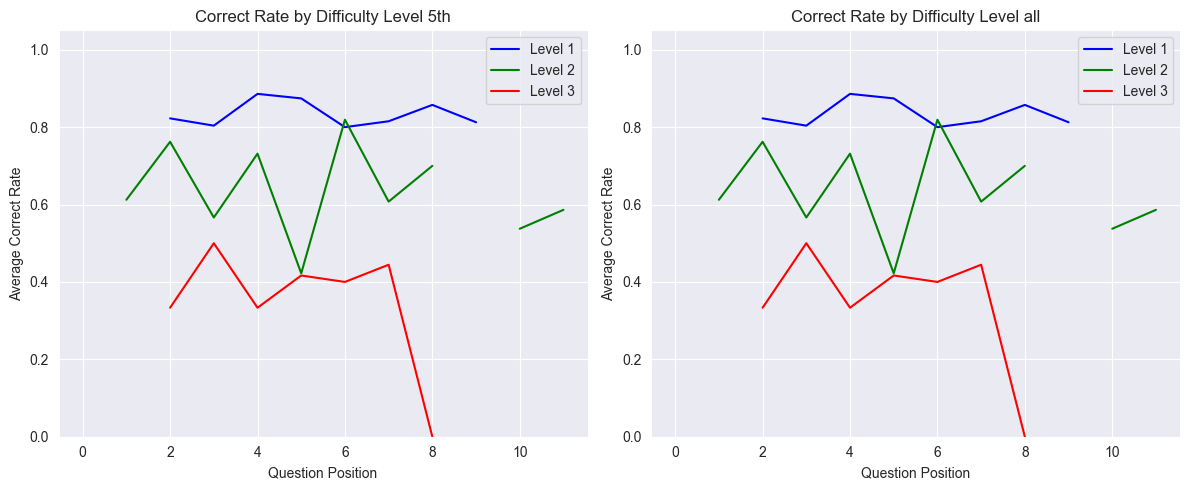

In [340]:
def correct_rate_groupby_difficulty(df: pd.DataFrame, length_lim=12):
    difficulty_levels = [1, 2, 3]
    level_index = {d: i for i, d in enumerate(difficulty_levels)}

    # 初始化儲存格：3種難度 × 每題位置
    correct_rates = [[[] for _ in range(length_lim)] for _ in range(len(difficulty_levels))]

    # 確保每列都含有 list 且長度足夠
    for _, row in df.iterrows():
        difficulties = row.get("difficulty_level", [])
        corrects = row.get("is_correct", [])
        for q in range(min(length_lim, len(difficulties), len(corrects))):
            d = difficulties[q]
            if d in level_index:
                i = level_index[d]
                correct_rates[i][q].append(corrects[q])

    # 對每個 bin 計算平均答對率（若無資料則為 NaN）
    output = []
    for level_rates in correct_rates:
        level_means = [np.mean(rates) if rates else np.nan for rates in level_rates]
        output.append(level_means)

    return output

output_5th = correct_rate_groupby_difficulty(tempdf.query('answer_length >= 12 and manual_book_vol_mode == 5'),length_lim= 12)
output_all = correct_rate_groupby_difficulty(tempdf.query('answer_length >= 12'),length_lim= 12)

difficulty_labels = ['Level 1', 'Level 2', 'Level 3']
line_colors = ['blue', 'green', 'red']
# 先修正 length 的取得
length = len(output_5th[0])

# 建 DataFrame
df_5th = pd.DataFrame({
    'Question Index': range(length),
    'Level 1': output_5th[0],
    'Level 2': output_5th[1],
    'Level 3': output_5th[2],
})
df_all = pd.DataFrame({
    'Question Index': range(length),
    'Level 1': output_all[0],
    'Level 2': output_all[1],
    'Level 3': output_all[2],
})

# 建立 1×2 的子圖
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 左圖：5th
ax = axs[0]
for label, color in zip(difficulty_labels, line_colors):
    ax.plot(df_5th['Question Index'], df_5th[label], label=label, color=color)
ax.set_xlabel("Question Position")
ax.set_ylabel("Average Correct Rate")
ax.set_title("Correct Rate by Difficulty Level 5th")
ax.legend()
ax.grid(True)
ax.set_ylim(0, 1.05)

# 右圖：all
ax = axs[1]
for label, color in zip(difficulty_labels, line_colors):
    ax.plot(df_all['Question Index'], df_all[label], label=label, color=color)
ax.set_xlabel("Question Position")
ax.set_ylabel("Average Correct Rate")
ax.set_title("Correct Rate by Difficulty Level all")
ax.legend()
ax.grid(True)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()


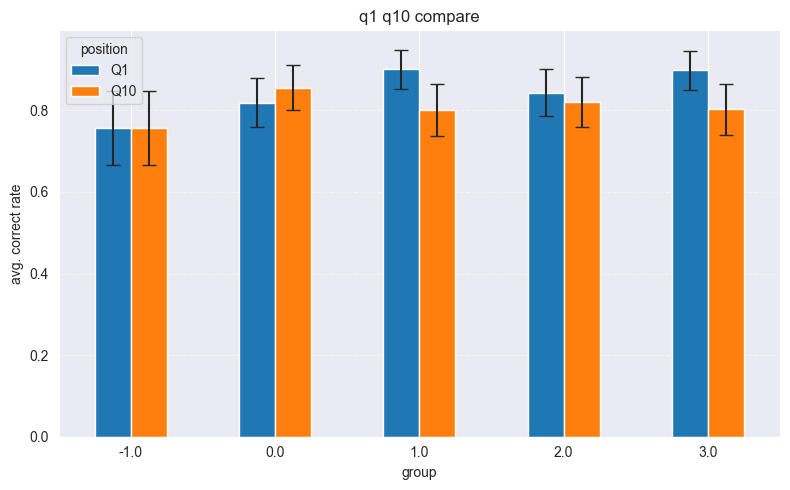

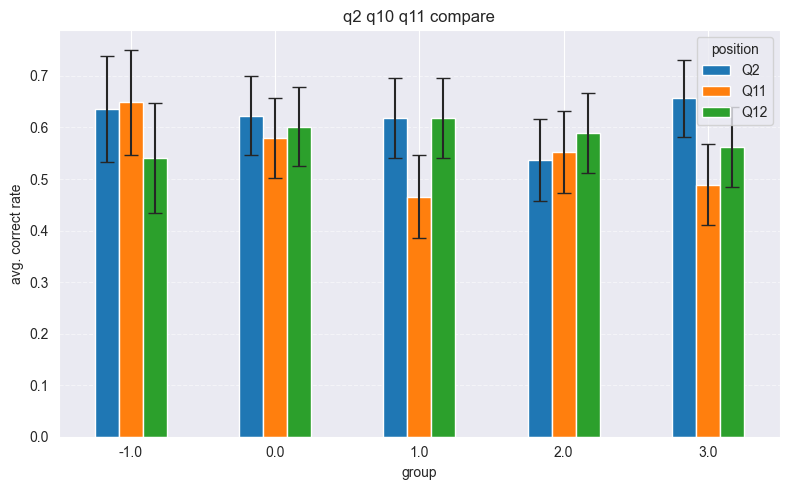

In [341]:

#   ’experiment_mode‘ (分組)
#   ’is_correct‘    (list of bool，對應各題作答是否正確)

def compute_question_rates(df, positions):
    """
    回傳 DataFrame，欄位為 experiment_mode, position, rate, sem
    positions: 題號索引 list (0-based)
    """
    records = []
    for grp, sub in df.groupby('experiment_mode'):
        for pos in positions:
            # 取出該組別所有 session 第 pos 題的正確率
            vals = sub['is_correct'] \
                    .apply(lambda seq: seq[pos] if len(seq) > pos else np.nan) \
                    .dropna().astype(float)
            mean = vals.mean()
            sem  = (vals.std(ddof=1) / np.sqrt(len(vals)))*1.83 if len(vals) > 1 else 0.0
            records.append({
                'experiment_mode': grp,
                'position':        f'Q{pos+1}',
                'rate':            mean,
                'sem':             sem
            })
    return pd.DataFrame(records)

df1 = compute_question_rates(testdfff, positions=[0, 9]) \
        .pivot(index='experiment_mode', columns='position', values=['rate','sem'])
rates1 = df1['rate']
sems1  = df1['sem']

ax = rates1.plot(
    kind='bar',
    yerr=sems1,
    figsize=(8,5),
    capsize=5,
    rot=0,
    title='q1 q10 compare'
)
ax.set_xlabel('group')
ax.set_ylabel('avg. correct rate')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 第二張：Q2, Q11, Q12
df2 = compute_question_rates(testdfff, positions=[1, 10, 11]) \
        .pivot(index='experiment_mode', columns='position', values=['rate','sem'])
rates2 = df2['rate']
sems2  = df2['sem']

# 指定想要的題號順序
order = ['Q2','Q11','Q12']

# 重新排列 rate 與 sem 的欄位
rates2_ord = rates2[order]
sems2_ord  = sems2[order]


ax = rates2_ord.plot(
    kind='bar',
    yerr=sems2_ord,
    figsize=(8,5),
    capsize=5,
    rot=0,
    title='q2 q10 q11 compare'
)
ax.set_xlabel('group')
ax.set_ylabel('avg. correct rate')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

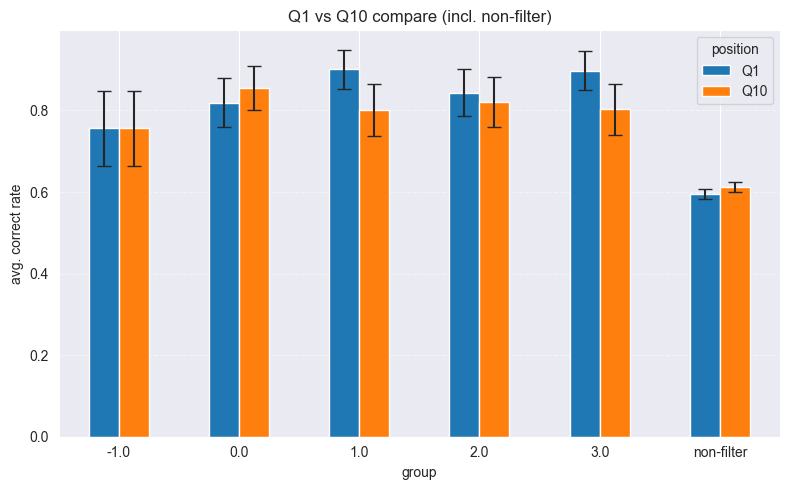

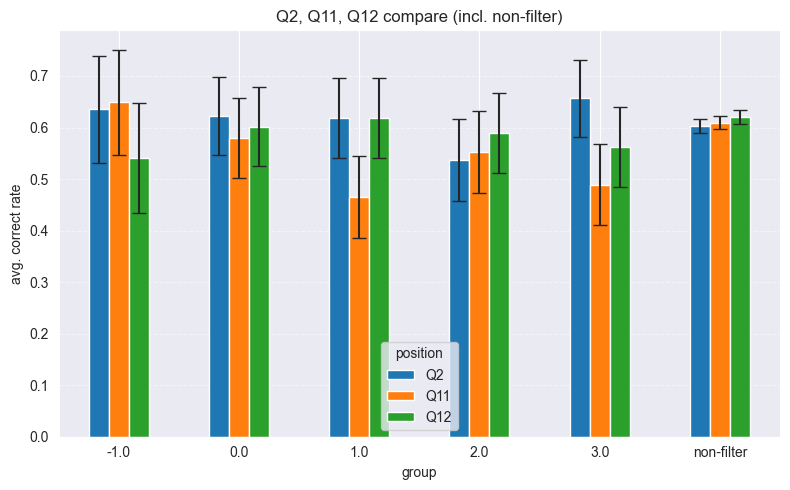

In [342]:
# 假設 testdff_all 已經是「非過濾」的 sessions（同樣經過 agg_sessions 但沒做 difficulty sequence 過濾）
# 第一張圖：Q1 (pos=0), Q10 (pos=9)

# 已過濾
df1_f = compute_question_rates(testdfff, positions=[0, 9]) \
            .pivot(index='experiment_mode', columns='position', values=['rate','sem'])

# 非過濾
tmp = non_filter_seq_df.copy()
tmp['experiment_mode'] = 'non-filter'
df1_nf = compute_question_rates(tmp, positions=[0, 9]) \
            .pivot(index='experiment_mode', columns='position', values=['rate','sem'])

# 合併 filtered 與 non-filter
rates1 = pd.concat([df1_f['rate'], df1_nf['rate']])
sems1  = pd.concat([df1_f['sem'],  df1_nf['sem']])

ax = rates1.plot(
    kind='bar',
    yerr=sems1,
    figsize=(8,5),
    capsize=5,
    rot=0,
    title='Q1 vs Q10 compare (incl. non-filter)'
)
ax.set_xlabel('group')
ax.set_ylabel('avg. correct rate')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../data/results/hist_of_correct_rate_easy.png",dpi=600)


# 第二張圖：Q2 (pos=1), Q11 (pos=10), Q12 (pos=11)

order = ['Q2','Q11','Q12']

# 已過濾
df2_f = compute_question_rates(testdfff, positions=[1, 10, 11]) \
            .pivot(index='experiment_mode', columns='position', values=['rate','sem'])

# 非過濾
tmp = non_filter_seq_df.copy()
tmp['experiment_mode'] = 'non-filter'
df2_nf = compute_question_rates(tmp, positions=[1, 10, 11]) \
            .pivot(index='experiment_mode', columns='position', values=['rate','sem'])

# 合併並依 order 重排
rates2 = pd.concat([df2_f['rate'], df2_nf['rate']])[order]
sems2  = pd.concat([df2_f['sem'],  df2_nf['sem']])[order]

ax = rates2.plot(
    kind='bar',
    yerr=sems2,
    figsize=(8,5),
    capsize=5,
    rot=0,
    title='Q2, Q11, Q12 compare (incl. non-filter)'
)
ax.set_xlabel('group')
ax.set_ylabel('avg. correct rate')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../data/results/hist_of_correct_rate_hard.png",dpi=600)

In [343]:


import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

def did_pair_analysis(df_sessions, non_filter_seq_df, q_pre, q_post, control_df_label='non-filter', control_df = True, control_label = 'non-filter'):
    """
    對 df_sessions 做 DiD 分析：
      q_pre  : 前測題號 (e.g. 2)
      q_post : 後測題號 (e.g. 11)
      control_label: 指定哪一組做為 baseline（必須和 experiment_mode 裡的值相同）
    回傳 group_means, did_effect, model
    """
    # 1. 複製 non-filter 並標記為 baseline
    if control_df :
        nf = non_filter_seq_df.copy()
        nf['experiment_mode'] = control_df_label
        df = pd.concat([df_sessions, nf], ignore_index=True)
    else:
        df = df_sessions
        df['experiment_mode'] = df['experiment_mode'].astype(int)

    # 3. 建立前後測正確欄位
    col_pre  = f'Q{q_pre}_corr'
    col_post = f'Q{q_post}_corr'
    df[col_pre]  = df['is_correct'].apply(lambda seq: seq[q_pre-1]  if len(seq) > q_pre-1  else np.nan)
    df[col_post] = df['is_correct'].apply(lambda seq: seq[q_post-1] if len(seq) > q_post-1 else np.nan)

    # 4. 去除 NA
    df = df[['experiment_mode', col_pre, col_post]].dropna()

    # 5. 轉長格式
    df_long = df.melt(
        id_vars='experiment_mode',
        value_vars=[col_pre, col_post],
        var_name='time',
        value_name='corr'
    )
    df_long['time_binary'] = df_long['time'].map({col_pre: 0, col_post: 1})

    # 6. 各組平均與差值
    group_means = (
        df_long
        .groupby(['experiment_mode', 'time'])['corr']
        .mean()
        .unstack()
    )
    group_means['diff'] = group_means[col_post] - group_means[col_pre]

    # 7. DiD effect
    control_diff = group_means.loc[control_label, 'diff']
    did_effect = group_means['diff'] - control_diff

    # 8. 回歸估計（主效果 + 交互效果）
    df_long['experiment_mode'] = df_long['experiment_mode'].astype('category')
    # 用 time_binary * C(...) 自動展開 main effect + interaction

    if isinstance(control_label, str):
        ref = f'"{control_label}"'
    else:
        ref = str(control_label)

    formula = (
        f'corr ~ time_binary * '
        f'C(experiment_mode, Treatment(reference={ref}))'
    )

    model = smf.ols(formula, data=df_long).fit()

    return group_means, did_effect, model
#
gm_1_10, de_1_10, mod_1_10 = did_pair_analysis(testdfff[testdfff['experiment_mode']!= -1], non_filter_seq_df, 1, 10)
print("Q2 vs Q11 - group means：\n", gm_1_10)
print("DiD effect：\n", de_1_10)
print(mod_1_10.summary())


# 範例：Q2 vs Q11
gm_2_11, de_2_11, mod_2_11 = did_pair_analysis(testdfff[testdfff['experiment_mode']!= -1], non_filter_seq_df, 2, 11)
print("Q2 vs Q11 - group means：\n", gm_2_11)
print("DiD effect：\n", de_2_11)
print(mod_2_11.summary())

# 範例：Q2 vs Q12
gm_2_12, de_2_12, mod_2_12 = did_pair_analysis(testdfff[testdfff['experiment_mode']!= -1], non_filter_seq_df, 2, 12)
print("Q2 vs Q12 - group means：\n", gm_2_12)
print("DiD effect：\n", de_2_12)
print(mod_2_12.summary())

Q2 vs Q11 - group means：
 time             Q10_corr   Q1_corr      diff
experiment_mode                              
0.0              0.855072  0.818841  0.036232
1.0              0.801527  0.900763 -0.099237
2.0              0.820896  0.843284 -0.022388
3.0              0.802920  0.897810 -0.094891
non-filter       0.611645  0.595301  0.016343
DiD effect：
 experiment_mode
0.0           0.019889
1.0          -0.115580
2.0          -0.038731
3.0          -0.111234
non-filter    0.000000
Name: diff, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   corr   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     28.05
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           1.21e-48
Time:                        03:19:52   Log-Likelihood:                -7400.6
No. Obs

In [344]:

import matplotlib.pyplot as plt

# 1. Prepare data for three scenarios
_df_all   = testdfff[testdfff['experiment_mode'] == 1]
df_0to3  = testdfff[testdfff['experiment_mode'].isin([0, 1, 2, 3])]
df_1to3  = testdfff[testdfff['experiment_mode'].isin([0, 2, 3])]

# Baseline datasets
baseline_non  = non_filter_seq_df.copy()
baseline_non['experiment_mode'] = 'non-filter'
baseline_zero = df_0to3[df_0to3['experiment_mode'] == -1].copy()

cases = [
    ('Scenario 1: Compare 1 with non-filter baseline',
     _df_all,  baseline_non,  'non-filter', True),
    ('Scenario 2: Compare groups 0,2,3 with group 1 baseline',
     df_0to3, baseline_non,  1, False),
    ('Scenario 3: Compare groups 0,2,3 with non-filter baseline',
     df_1to3, baseline_non,  'non-filter', True),
]


# 2. Run analysis and print results
results = {}
for name, df_in, df_ctrl, ctl, mdf in cases:
    print(f"\n===== {name} =====")
    results[name] = {}
    for q_pre, q_post in [(1, 10), (2, 11), (2, 12)]:
        print(f"\n--- Q{q_pre} vs Q{q_post} ---")
        gm, de, model = did_pair_analysis(
            df_sessions=df_in,
            non_filter_seq_df=df_ctrl,
            q_pre=q_pre,
            q_post=q_post,
            control_label=ctl,
            control_df=mdf
        )
        print("Group means:\n", gm)
        print("DiD effects:\n", de)
        print(model.summary())
        results[name][f'Q{q_pre} vs Q{q_post}'] = (de, ctl)



===== Scenario 1: Compare 1 with non-filter baseline =====

--- Q1 vs Q10 ---
Group means:
 time             Q10_corr   Q1_corr      diff
experiment_mode                              
1.0              0.801527  0.900763 -0.099237
non-filter       0.611645  0.595301  0.016343
DiD effects:
 experiment_mode
1.0          -0.11558
non-filter    0.00000
Name: diff, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   corr   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     23.91
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           2.06e-15
Time:                        03:19:52   Log-Likelihood:                -7010.9
No. Observations:               10052   AIC:                         1.403e+04
Df Residuals:                   10048   BIC:                         

/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/1138802512.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['experiment_mode'] = df['experiment_mode'].astype(int)
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/1138802512.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_pre]  = df['is_correct'].apply(lambda seq: seq[q_pre-1]  if len(seq) > q_pre-1  else np.nan)
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/1138802512.py:26: SettingWithCo

/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/1138802512.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['experiment_mode'] = df['experiment_mode'].astype(int)
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/1138802512.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_pre]  = df['is_correct'].apply(lambda seq: seq[q_pre-1]  if len(seq) > q_pre-1  else np.nan)
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/1138802512.py:26: SettingWithCo

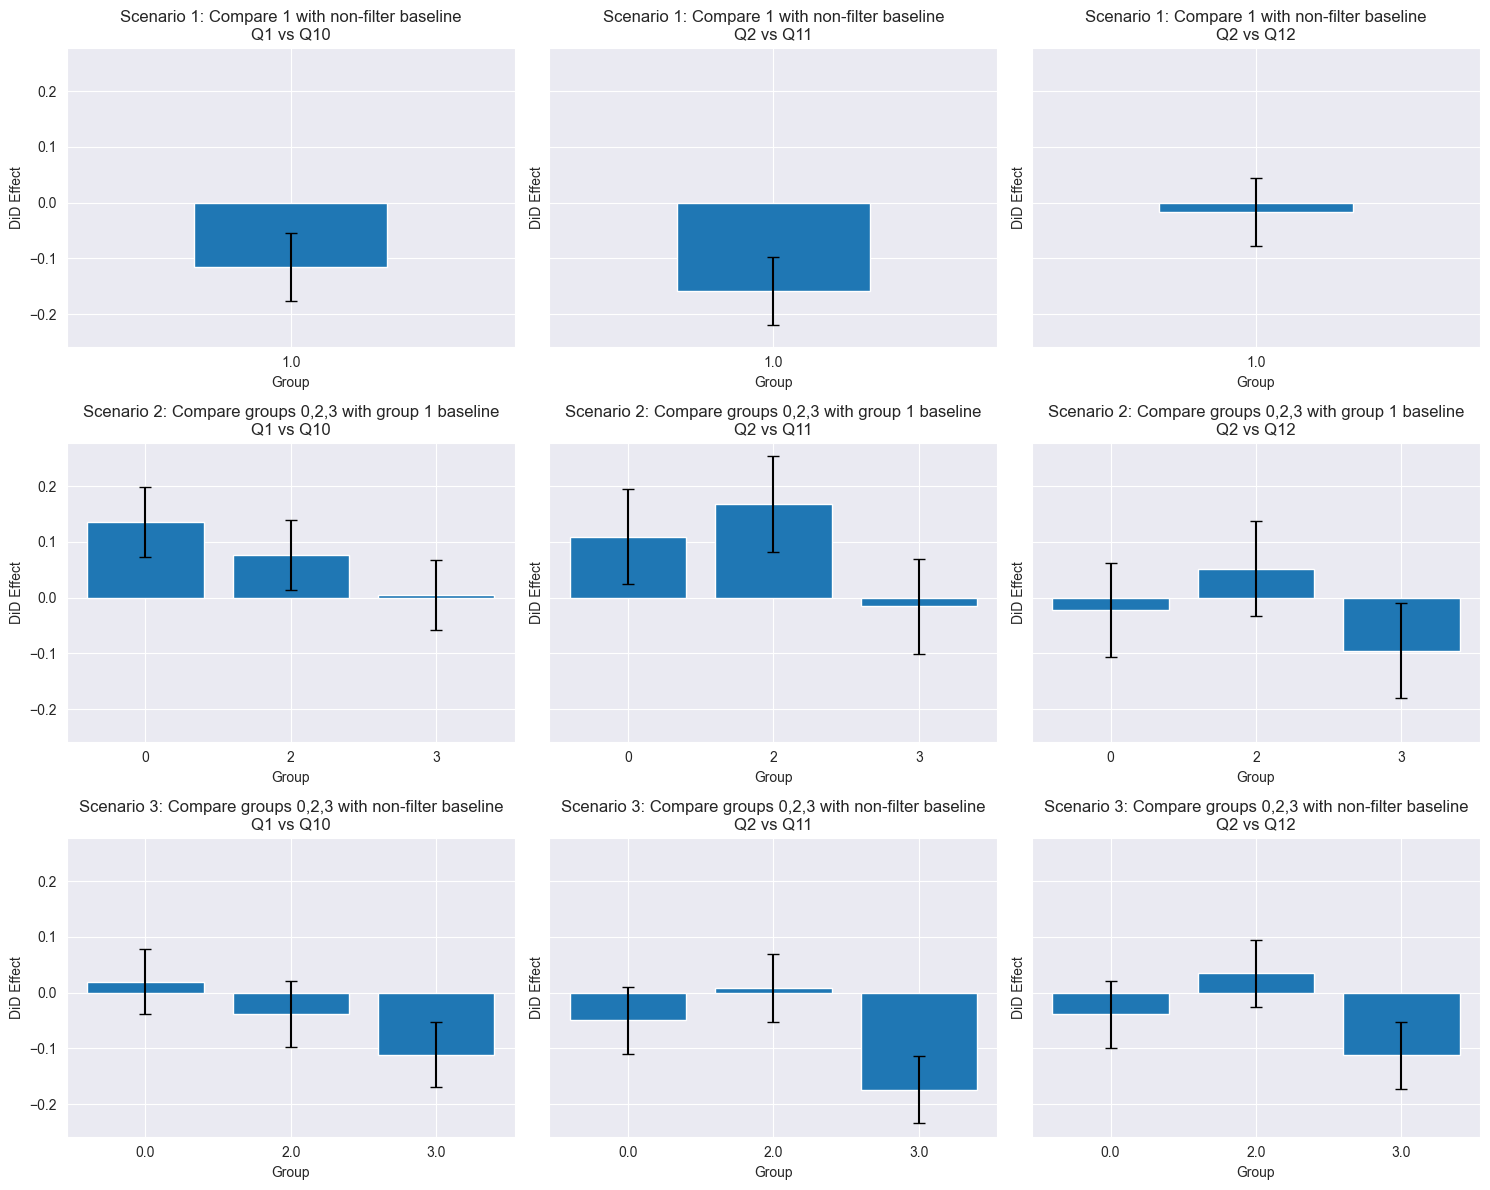

In [345]:
# 1. Define the question pairs and subplot grid
questions = [(1, 10), (2, 11), (2, 12)]
n_rows = len(cases)
n_cols = len(questions)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False,sharey=True)

# 2. Loop through scenarios and question pairs
for i, (name, df_in, df_ctrl, ctl, mdf) in enumerate(cases):
    for j, (q_pre, q_post) in enumerate(questions):
        ax = axes[i][j]

        # Re-run DiD to get did_effect and model (for SEs)
        gm, de, model = did_pair_analysis(
            df_sessions=df_in,
            non_filter_seq_df=df_ctrl,
            q_pre=q_pre,
            q_post=q_post,
            control_df_label=ctl,
            control_df=mdf,
            control_label=ctl
        )

        # Drop baseline and prepare bar heights
        de_plot = de.drop(ctl)
        groups = de_plot.index.astype(str)
        effects = de_plot.values

        # Compute error bars from model bse for interaction terms
        errs = []
        # Prepare reference literal matching the formula
        if isinstance(ctl, str):
            ref = f'"{ctl}"'
        else:
            ref = str(ctl)
        for grp in de_plot.index:
            param_name = f'time_binary:C(experiment_mode, Treatment(reference={ref}))[T.{grp}]'
            errs.append(model.bse[param_name])

        # Plot bar with error bars
        ax.bar(groups, effects, yerr=errs, capsize=4)
        if len(groups) == 1:
            ax.margins(x=0.66)   # 在左右各留 50% 的空白
        ax.set_title(f"{name}\nQ{q_pre} vs Q{q_post}")
        ax.set_xlabel("Group")
        ax.set_ylabel("DiD Effect")

# 3. Layout and show
plt.tight_layout()
plt.savefig("../data/results/did_of_correct_rate.png",dpi=600)


/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/1138802512.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['experiment_mode'] = df['experiment_mode'].astype(int)
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/1138802512.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_pre]  = df['is_correct'].apply(lambda seq: seq[q_pre-1]  if len(seq) > q_pre-1  else np.nan)
/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/1138802512.py:26: SettingWithCo

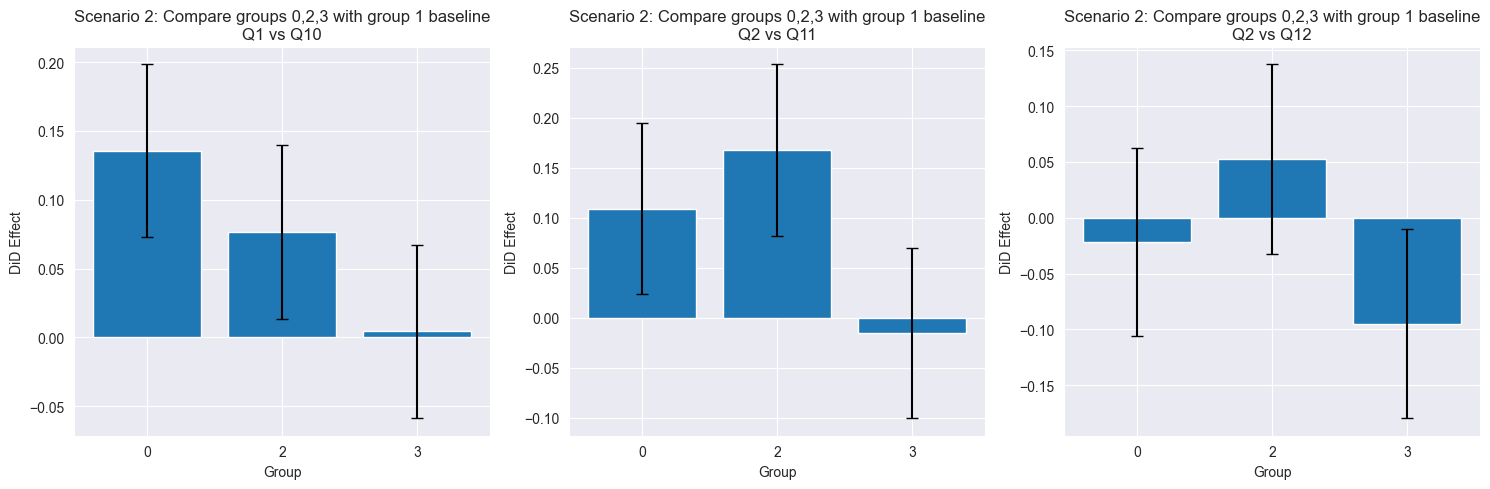

In [346]:
fig, axes = plt.subplots(1,3,figsize = (15,5))


name, df_in, df_ctrl, ctl, mdf = ('Scenario 2: Compare groups 0,2,3 with group 1 baseline',
     df_0to3, baseline_non,  1, False)

for j, (q_pre, q_post) in enumerate(questions):
        ax = axes[j]

        # Re-run DiD to get did_effect and model (for SEs)
        gm, de, model = did_pair_analysis(
            df_sessions=df_in,
            non_filter_seq_df=df_ctrl,
            q_pre=q_pre,
            q_post=q_post,
            control_df_label=ctl,
            control_df=mdf,
            control_label=ctl
        )

        # Drop baseline and prepare bar heights
        de_plot = de.drop(ctl)
        groups = de_plot.index.astype(str)
        effects = de_plot.values

        # Compute error bars from model bse for interaction terms
        errs = []
        # Prepare reference literal matching the formula
        if isinstance(ctl, str):
            ref = f'"{ctl}"'
        else:
            ref = str(ctl)
        for grp in de_plot.index:
            param_name = f'time_binary:C(experiment_mode, Treatment(reference={ref}))[T.{grp}]'
            errs.append(model.bse[param_name])

        # Plot bar with error bars
        ax.bar(groups, effects, yerr=errs, capsize=4)
        if len(groups) == 1:
            ax.margins(x=0.66)   # 在左右各留 50% 的空白
        ax.set_title(f"{name}\nQ{q_pre} vs Q{q_post}")
        ax.set_xlabel("Group")
        ax.set_ylabel("DiD Effect")
plt.tight_layout()
plt.show()

time             Q10_corr   Q1_corr      diff
experiment_mode                              
0                0.876106  1.000000 -0.123894
1                0.813559  1.000000 -0.186441
2                0.876106  1.000000 -0.123894
3                0.821138  1.000000 -0.178862
non-filter       0.611645  0.595301  0.016343
time             Q11_corr   Q2_corr      diff
experiment_mode                              
0                0.584071  0.646018 -0.061947
1                0.449153  0.618644 -0.169492
2                0.566372  0.557522  0.008850
3                0.504065  0.666667 -0.162602
non-filter       0.609397  0.603064  0.006333
time             Q12_corr   Q2_corr      diff
experiment_mode                              
0                0.637168  0.646018 -0.008850
1                0.627119  0.618644  0.008475
2                0.610619  0.557522  0.053097
3                0.577236  0.666667 -0.089431
non-filter       0.620429  0.603064  0.017365


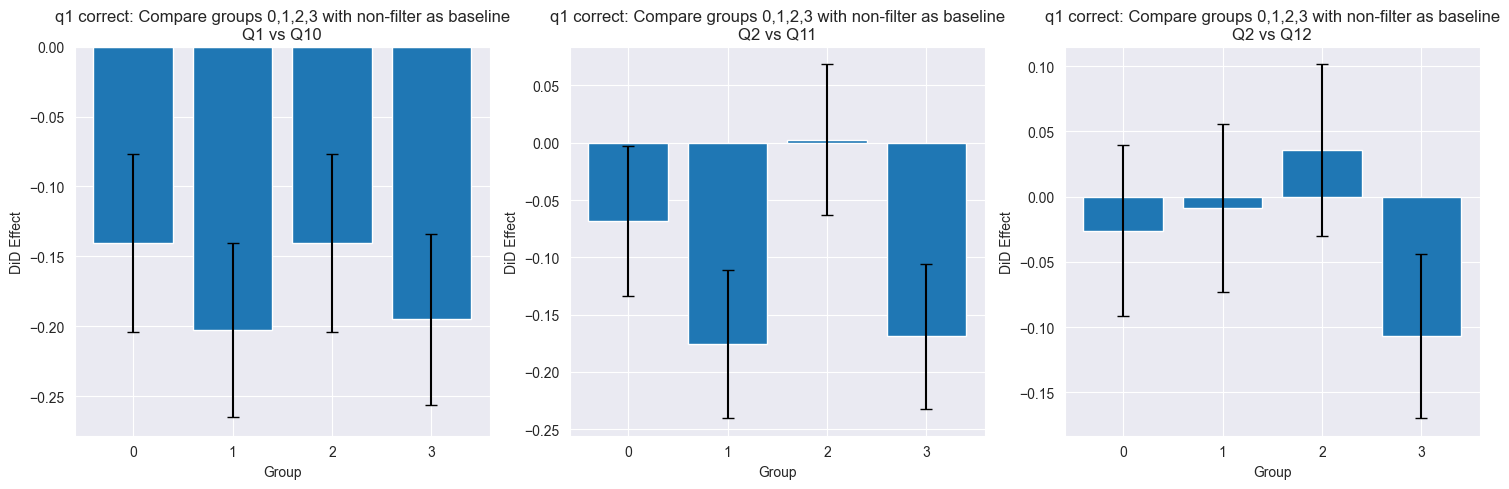

In [347]:
fig, axes = plt.subplots(1,3,figsize = (15,5))

mask_0to3 = df_0to3['is_correct'].apply(lambda x : True if x[0] == 1 else False)
name, df_in, df_ctrl, ctl, mdf = ('q1 correct: Compare groups 0,1,2,3 with non-filter as baseline',
     df_0to3[mask_0to3], baseline_non,  'non-filter', True)

for j, (q_pre, q_post) in enumerate(questions):
        ax = axes[j]

        # Re-run DiD to get did_effect and model (for SEs)
        gm, de, model = did_pair_analysis(
            df_sessions=df_in,
            non_filter_seq_df=df_ctrl,
            q_pre=q_pre,
            q_post=q_post,
            control_df_label=ctl,
            control_df=mdf,
            control_label=ctl
        )

        # Drop baseline and prepare bar heights
        de_plot = de.drop(ctl)
        groups = de_plot.index.astype(str)
        effects = de_plot.values

        # Compute error bars from model bse for interaction terms
        errs = []
        # Prepare reference literal matching the formula
        if isinstance(ctl, str):
            ref = f'"{ctl}"'
        else:
            ref = str(ctl)
        for grp in de_plot.index:
            param_name = f'time_binary:C(experiment_mode, Treatment(reference={ref}))[T.{grp}]'
            errs.append(model.bse[param_name])

        # Plot bar with error bars
        ax.bar(groups, effects, yerr=errs, capsize=4)
        if len(groups) == 1:
            ax.margins(x=0.66)   # 在左右各留 50% 的空白
        ax.set_title(f"{name}\nQ{q_pre} vs Q{q_post}")
        ax.set_xlabel("Group")
        ax.set_ylabel("DiD Effect")
        print(gm)
plt.tight_layout()
plt.show()

In [348]:

# 讀取資料
time_df = pd.read_json('/Users/eric/Documents/SchoolCourses/PaGamO/data/processed/question_data.json')

# 篩選必要欄位
time_df = time_df[['time_diff', 'difficulty_level', 'section_id', 'user_id','is_correct']]
time_df = time_df[time_df['time_diff'] <= 60*30]
time_df = time_df[time_df['time_diff'] != 0]

# 處理欄位型別
time_df = time_df.dropna(subset=['time_diff', 'difficulty_level', 'section_id'])
time_df['difficulty_level'] = time_df['difficulty_level'].astype(int).astype(str)
time_df['difficulty_level'] = pd.Categorical(time_df['difficulty_level'], categories=['1', '2', '3'])

In [349]:
time_df[time_df.time_diff == 0].count()

time_diff           0
difficulty_level    0
section_id          0
user_id             0
is_correct          0
dtype: int64

In [350]:

model = smf.ols(
    formula='np.log(time_diff) ~ C(difficulty_level, Treatment(reference="1")) + C(section_id)',
    data=time_df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(time_diff)   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     18.45
Date:                Mon, 04 Aug 2025   Prob (F-statistic):               0.00
Time:                        03:20:16   Log-Likelihood:            -4.5960e+05
No. Observations:              328646   AIC:                         9.209e+05
Df Residuals:                  327789   BIC:                         9.301e+05
Df Model:                         856                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [351]:
print(model.params)


Intercept                                             3.144197
C(difficulty_level, Treatment(reference="1"))[T.2]    0.079553
C(difficulty_level, Treatment(reference="1"))[T.3]    0.075363
C(section_id)[T.-9211731756706304242]                -0.572084
C(section_id)[T.-9198014272499051343]                -0.114604
                                                        ...   
C(section_id)[T.9151048000799462961]                  0.034624
C(section_id)[T.9151464306786095852]                 -0.332469
C(section_id)[T.9177551116238814866]                 -0.195771
C(section_id)[T.9210568602983011419]                 -0.119140
C(section_id)[T.9222777303019271936]                 -0.557764
Length: 857, dtype: float64


(array([   40.,   504.,  1874.,  3025.,  5838.,  9124., 12323., 14301.,
        15105., 14519., 13905., 13154., 11878., 11015.,  9922.,  9331.,
         8503.,  7866.,  7330.,  6860.,  6462.,  5863.,  5556.,  5283.,
         4755.,  4526.,  4180.,  3909.,  3709.,  3466.,  3261.,  3074.,
         2874.,  2775.,  2658.,  2532.,  2441.,  2285.,  2220.,  2006.,
         2011.,  1901.,  1884.,  1704.,  1746.,  1667.,  1582.,  1450.,
         1526.,  1477.,  1373.,  1311.,  1216.,  1239.,  1168.,  1111.,
         1116.,  1053.,   990.,     0.,  1066.,   921.,   897.,   882.,
          821.,   866.,   784.,   769.,   800.,   794.,   719.,   679.,
          710.,   643.,   638.,   596.,   642.,   593.,   569.,   538.,
          535.,   577.,   571.,   498.,   510.,   490.,   492.,   474.,
          450.,   456.,   447.,   399.,   394.,   399.,   393.,   407.,
          365.,   348.,   385.,   344.,   344.,   332.,   318.,   318.,
          305.,   356.,   332.,   325.,   288.,   277.,   274., 

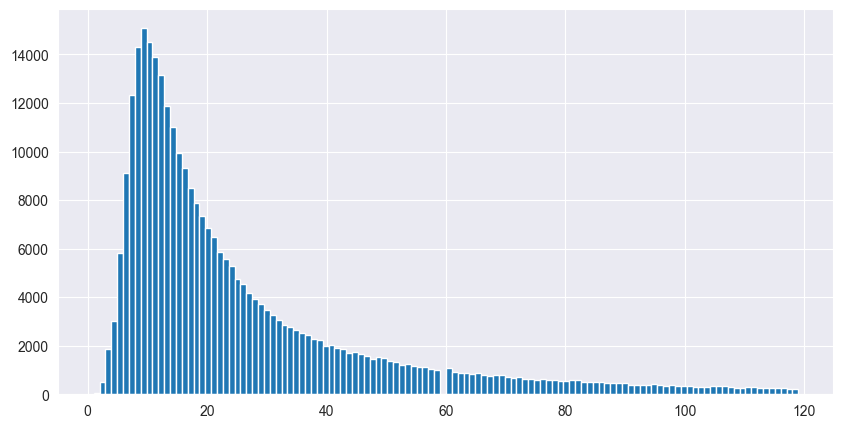

In [352]:
plt.figure(figsize = (10,5))


plt.hist(time_df.query('time_diff < 120').time_diff,bins = 120)


In [353]:
# 假設你事先已經做了：
# import pandas as pd
# time_df = pd.read_json("…/question_data.json")
%R -i time_df

/Users/eric/Documents/SchoolCourses/PaGamO/venv/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "section_id". Fall back to string conversion. The error is: integer 8792496549026144974 does not fit 'int'
  warnings.warn('Error while trying to convert '
/Users/eric/Documents/SchoolCourses/PaGamO/venv/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "user_id". Fall back to string conversion. The error is: integer -5349201036262240550 does not fit 'int'
  warnings.warn('Error while trying to convert '


In [354]:
%%R
library(fixest)

# 設定 baseline
time_df$difficulty_level <- relevel(factor(time_df$difficulty_level), ref = "1")

model <- feols(
  time_diff ~ 1 + difficulty_level  | section_id + user_id,
  data = time_df
)


summary(model, intercept = TRUE)

mean(time_df$time_diff)

[1] 45.28506


In [355]:
%%R

model <- feglm(is_correct ~ time_diff | difficulty_level + section_id + user_id , data = time_df, family  = binomial(link = "logit"))

summary(model)

GLM estimation, family = binomial(link = "logit"), Dep. Var.: is_correct
Observations: 327,313
Fixed-effects: difficulty_level: 3,  section_id: 719,  user_id: 2,607
Standard-errors: Clustered (difficulty_level) 
           Estimate Std. Error  z value   Pr(>|z|)    
time_diff -0.000201      5e-05 -4.04028 5.3387e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -181,882.2   Adj. Pseudo R2: 0.123637
           BIC:  406,025.5     Squared Cor.: 0.166971


NOTE: 0/136/158 fixed-effects (1,333 observations) removed because of only 0 (or only 1) outcomes.


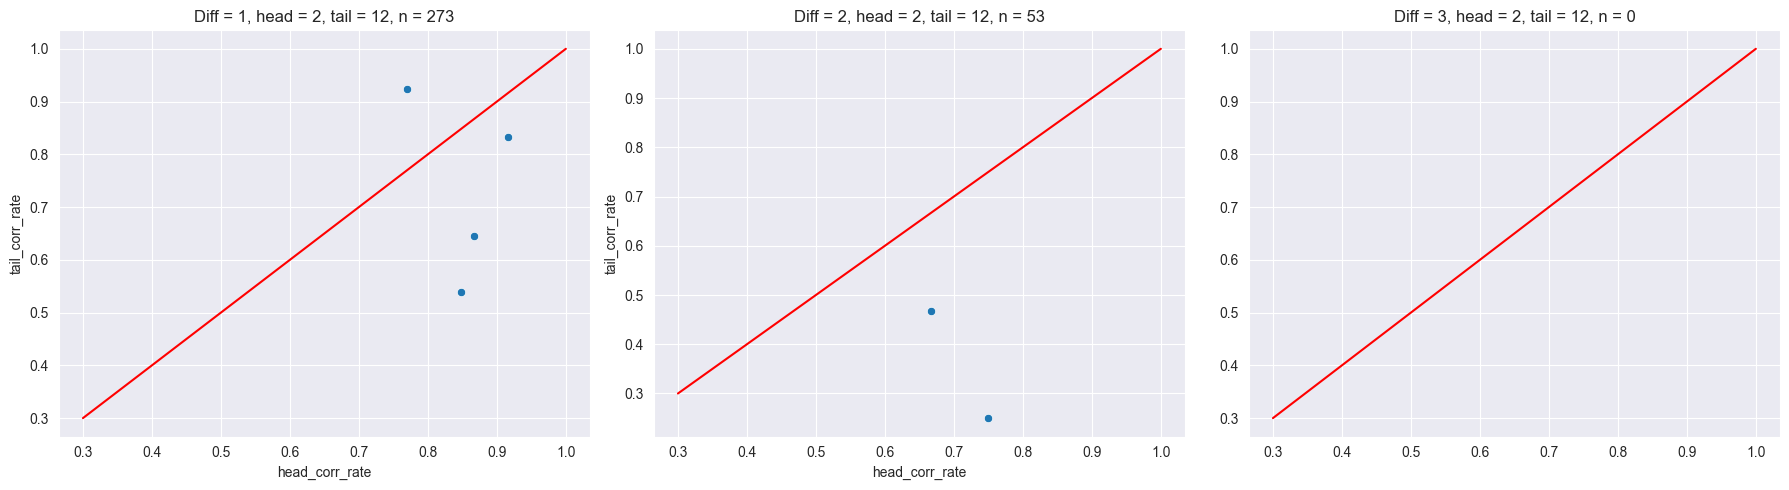

In [356]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def scatter_of_head_tail(df_: pd.DataFrame, head: int = 2, tail: int = 12, diff_level: int = 1, ax=None):
    df = df_.copy()

    h_temp, t_temp, hd_temp, td_temp = [], [], [], []

    for ans, diff in zip(df['is_correct'], df['difficulty_level']):
        if len(ans) > tail:
            h_temp.append(ans[head])
            t_temp.append(ans[tail])
            hd_temp.append(diff[head])
            td_temp.append(diff[tail])
        else:
            h_temp.append(np.nan)
            t_temp.append(np.nan)
            hd_temp.append(np.nan)
            td_temp.append(np.nan)

    df.loc[:, 'head_corr'] = h_temp
    df.loc[:, 'tail_corr'] = t_temp
    df.loc[:, 'head_diff'] = hd_temp
    df.loc[:, 'tail_diff'] = td_temp
    df.loc[:, 'section'] = df['section_id'].apply(lambda x: x[0])

    df = df[(df['head_diff'] == diff_level) & (df['tail_diff'] == diff_level)]

    scdf = df.groupby('section').agg(
        head_corr_rate=('head_corr', 'mean'),
        tail_corr_rate=('tail_corr', 'mean'),
        n=('head_corr', 'count')
    ).reset_index()

    # 使用傳入的 Axes 或新建
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # 畫圖
    sns.scatterplot(data=scdf[scdf['n'] > 10],
                    x='head_corr_rate',
                    y='tail_corr_rate',
                    ax=ax)

    seq = np.linspace(0.3, 1)
    ax.plot(seq, seq, color='red')
    ax.set_title(f"Diff = {diff_level}, head = {head}, tail = {tail}, n = {scdf['n'].sum()}")

    return ax


fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row 3 columns

for i in range(3):
    scatter_of_head_tail(testdfff[testdfff['answer_length'] >= 12], diff_level=i+1, ax=axes[i])

plt.tight_layout()
plt.show()


[-1.  0.  1.  2.  3.]
dict_keys([np.float64(-1.0), np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0)])
74
138
131
134
137
[-1.  0.  1.  2.  3.]


/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_28002/314750164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdfff['experiment_mode'] = testdfff['experiment_mode'].fillna(value = -1)


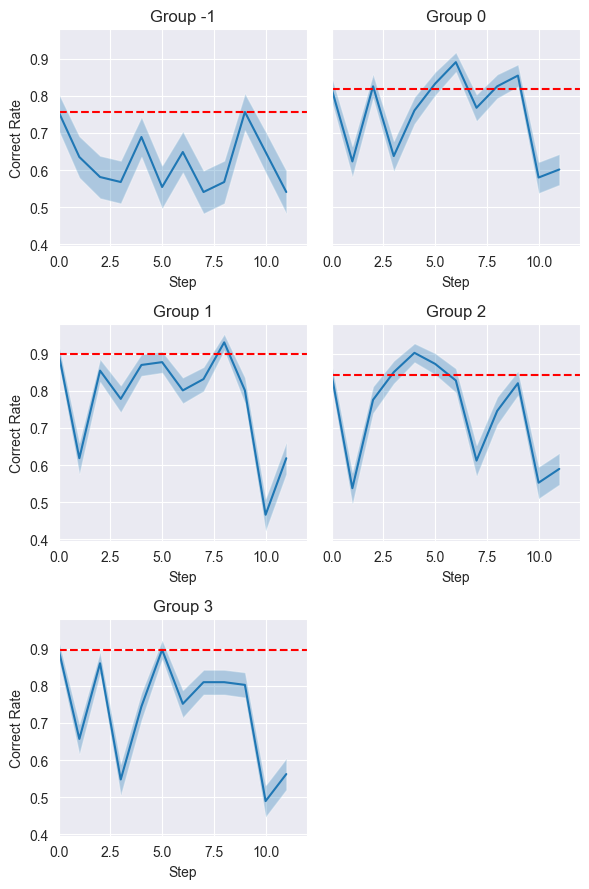

In [357]:

# analyze the correct rate in each order
def correct_rate(seqs: list[list]):
    print(len(seqs))
    output = []
    _maxlen = max(([len(seq) for seq in seqs]))
    for idx in range(_maxlen):
        temp = []
        for seq in seqs:
            if len(seq) > idx:
                temp.append(seq[idx])
        output.append(temp)
    mean = [statistics.mean(seq) for seq in output]
    se = [np.std(seq)/np.sqrt(len(seq)) if len(seq) > 1 else 0 for seq in output]
    n = [len(seq) for seq in output]

    return [mean, se, n]

testdfff['experiment_mode'] = testdfff['experiment_mode'].fillna(value = -1)
exp_labels = testdfff['experiment_mode'].unique()
exp_labels.sort()
print(exp_labels)

dfs = dict()
for lab in exp_labels:
    mask1 = testdfff['experiment_mode'] == lab if lab is not None else testdfff['experiment_mode'].isna()
    mask2 = 12 <= testdfff['answer_length']
    # mask3 = 5 < testdfff['answer_length']
    # mask = mask1 & mask2 & mask3
    mask = mask1 & mask2
    dfs[lab] = testdfff[mask]
    dfs[lab] = dfs[lab]
print(dfs.keys())
correct_rate_list = [correct_rate(dfs[key]['is_correct'].to_list()) for key in exp_labels]
correct_rate_mean = [_[0] for _ in correct_rate_list]
correct_rate_se = [_[1] for _ in correct_rate_list]
correct_rate_sample_size = [_[2] for _ in correct_rate_list]
print(exp_labels)




def plot_correct_rate_with_sd(correct_rate_seq, sd_seq=None, length_lim=None,
                              figsize=(12, 18), dpi=100, return_axs=False):
    """
    繪製多組 correct_rate 與其標準差區間，回傳 fig, axs 供後續操作。

    參數:
    - correct_rate_seq: list of lists/arrays，共有 5 組 correct_rate。
    - sd_seq: list of lists/arrays，與 correct_rate_seq 對應的標準差 (可選)。
    - length_lim: int，限定繪圖的長度 (可選)。
    - figsize: tuple，整體 figure 大小。
    - dpi: int，回傳圖的解析度 (僅影響顯示，存檔時可另行指定)。
    - return_axs: bool，若為 True，回傳 (fig, axs)；否則只回傳 fig。

    回傳:
    - fig: matplotlib.figure.Figure
    - axs: numpy.ndarray of Axes (只有在 return_axs=True 時回傳)
    """
    # 建立 figure + 3x2 子圖
    fig, axs = plt.subplots(3, 2, figsize=figsize, dpi=dpi, sharey=True)
    axs = axs.flatten()

    # 確定要畫幾個子圖（這裡預設畫前 5 組）
    n_plots = min(5, len(correct_rate_seq))

    for i in range(n_plots):
        length = len(correct_rate_seq[i]) if length_lim is None else length_lim
        df = pd.DataFrame({
            'step': range(length),
            'correct_rate': correct_rate_seq[i][:length]
        })
        ax = axs[i]

        # 若有 sd 序列，就計算上下界
        if sd_seq is not None:
            df['sd'] = sd_seq[i][:length]
            df['upper'] = df['correct_rate'] + df['sd']
            df['lower'] = df['correct_rate'] - df['sd']

        # 畫線與區間
        sns.lineplot(data=df, x='step', y='correct_rate', ax=ax)
        if sd_seq is not None:
            ax.fill_between(df['step'], df['lower'], df['upper'], alpha=0.3)

        # 畫初始值的紅色虛線
        ax.hlines(df.loc[0, 'correct_rate'], xmin=0, xmax=length,
                  colors='red', linestyles='dashed')

        ax.set_xlim(0, length if length_lim is None else length_lim)
        ax.set_title(f"Group {i-1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Correct Rate")
        ax.grid(True)

    # 清除多餘的子圖
    for j in range(n_plots, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()

    if return_axs:
        return fig, axs[:n_plots]
    else:
        return fig



# 僅畫線

#plot_correct_rate_with_sd(correct_rate_seq, sd_seq=correct_rate_se, length_lim=20)

fig, axes = plot_correct_rate_with_sd(correct_rate_mean, correct_rate_se, length_lim=12,
                                      figsize=(6, 9), return_axs=True)

In [358]:
# average diffculty
testdff.query('manual_book_vol_mode == 5',inplace=True)
testdff['mean_difficult'] = testdff['difficulty_level'].apply(lambda x : np.mean(x[:12]))

In [359]:
testdff

,user_id,gamecharacter_id,session_id,is_correct,difficulty_level,experiment_index,question_id,subject_name,section_id,section_name,...,manual_book_vol,time_diff,start_time,end_time,session_length,answer_length,experiment_mode,manual_book_vol_mode,subject_name_mode,mean_difficult
"(-9215975131138636025, 2806305522055252713, 1)",-9215975131138636025,2806305522055252713,1,"[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, ...","[1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[5986642740406154097, -1814475752912975980, 57...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[None, 102.0, 55.0, 13.0, 10.0, 16.0, 120.0, 1...",2025-04-14 02:01:31,2025-04-14 02:20:41,1150,35,1.0,5,數學,1.250000
"(-9186786909406172865, -6982760217073593162, 2)",-9186786909406172865,-6982760217073593162,2,"[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[2, 2, 2, 2, 3, 2, 1, 2, 2, 3, 3, 2]","[None, None, None, None, None, None, None, Non...","[-7934014245957245064, 4769790906435938974, -4...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學]","[-9042528178512436726, 145845299402454255, 145...","[5 十進位結構, 3 容積, 3 容積, 1 體積, 2 分數的計算, 4 小數的乘法, ...",...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]","[3021932.0, 118.0, 55.0, 41.0, 21.0, 27.0, 10....",2025-04-14 13:51:26,2025-04-14 13:57:00,334,12,2.0,5,數學,2.166667
"(-9184402346128308861, -4396277618843047512, 1)",-9184402346128308861,-4396277618843047512,1,"[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, ...","[3, 1, 2, 2, 2, 3, 3, 2, 1, 2, 2, 2, 1, 2, 2, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[2231686025512216228, -5726815239356025282, -7...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[6084119510007883763, 145845299402454255, 1458...","[4 小數的乘法, 3 容積, 3 容積, 4 小數的乘法, 5 十進位結構, 4 小數的乘...",...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[None, 20.0, 43.0, 19.0, 13.0, 42.0, 23.0, 17....",2025-04-21 10:51:56,2025-04-21 11:08:42,1006,39,2.0,5,數學,2.083333
"(-9183206904374525062, -3002798077988015695, 2)",-9183206904374525062,-3002798077988015695,2,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, ...","[2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 3, 2, ...","[None, None, None, None, None, None, None, Non...","[-1897899015581030178, 6916997226709832338, -4...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, 522...","[1 體積, 1 體積, 2 分數的計算, 1 體積, 2 分數的計算, 2 分數的計算, ...",...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[521163.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2025-02-25 09:17:04,2025-02-25 09:17:04,0,25,-1.0,5,數學,1.833333
"(-9183206904374525062, -3002798077988015695, 3)",-9183206904374525062,-3002798077988015695,3,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]","[2, 2, 2, 2, 2, 2, 3, 1, 2, 3, 2, 2, 2, 2]","[None, None, None, None, None, None, None, Non...","[-2233377592059294268, 4816520945223989067, -4...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[5223737939809232457, -247801341597882458, 522...","[2 分數的計算, 1 體積, 2 分數的計算, 2 分數的計算, 2 分數的計算, 1 體...",...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]","[169628.0, 6.0, 5.0, 5.0, 3.0, 6.0, 179.0, 4.0...",2025-02-27 08:24:12,2025-02-27 08:28:02,230,14,-1.0,5,數學,2.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(9219658531437984765, -4405050303537733295, 1)",9219658531437984765,-4405050303537733295,1,"[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 2, 1, 3, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...","[None, None, None, None, None, None, None, Non...","[-5406777392837291699, -3286862775113972652, -...","[數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數學, 數...","[-247801341597882458, -247801341597882458, -24...","[1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體積, 1 體...",...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[None, 26.0, 29.0, 12.0, 

In [360]:
testdff.groupby('experiment_mode').describe().loc[:,'mean_difficult']

,count,mean,min,25%,50%,75%,max,std
experiment_mode,,,,,,,,
-1.0,4895.0,1.783316,1.0,1.583333,1.750000,2.000000,3.000000,0.349051
0.0,666.0,1.698574,1.0,1.500000,1.583333,1.916667,2.666667,0.318455
1.0,667.0,1.624688,1.0,1.250000,1.583333,2.000000,3.000000,0.411514
2.0,645.0,1.757752,1.0,1.500000,1.666667,2.000000,3.000000,0.332303
3.0,591.0,1.728426,1.0,1.500000,1.583333,2.000000,3.000000,0.324411
